# **Consommation des bâtiments en Seattle: Analyse exploratoire**

## *Importation des données*

In [3]:
import sys
import importlib.metadata

# Afficher la version de Python
print("Python version:", sys.version)

# Afficher la version des bibliothèques déjà importées
print('\n'.join(f'{m.__name__} - {m.__version__}'
         for m in globals().values()
         if getattr(m, '__version__', None)))

Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
json - 2.0.9
pandas - 2.2.2


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
df_energy=pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [5]:
display(df_energy.head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [6]:
pd.options.display.max_columns = 70

## *Description des données*

In [8]:
display(df_energy.dtypes)

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

In [9]:
Type_building= df_energy.groupby('BuildingType')['OSEBuildingID'].nunique()
print(Type_building)

BuildingType
Campus                    24
Multifamily HR (10+)     110
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
NonResidential          1460
Nonresidential COS        85
Nonresidential WA          1
SPS-District K-12         98
Name: OSEBuildingID, dtype: int64


Nous voyons qu'il y a 8 différents type de building: 

- Campus
- Multifamily HR (10+): immeuble résidentiel multifamilial à haute densité, comprenant 10 unités ou plus.
- Multifamily LR (1-4): immeuble résidentiel multifamilial à faible densité, avec de 1 à 4 unités
- Multifamily MR (5-9): immeuble résidentiel multifamilial de densité moyenne, avec entre 5 et 9 unités
- **NonResidential: bâtiments non résidentiels, tels que des bureaux, des commerces ou des bâtiments industriels**
- **Nonresidential COS: des bâtiments non résidentiels de type "Commercial Office Space" (Espace de bureau commercial). Cela inclut des bureaux utilisés pour des activités professionnelles, commerciales ou administratives.**
- **Nonresidential WA: bâtiment non résidentiel en rapport avec les exigences spécifiques de l'État de Washington**
- **SPS-District K-12: bâtiments scolaires dans le district de Seattle Public Schools (SPS), des écoles primaires et secondaires, allant de la maternelle (K) jusqu'à la 12e année** 

In [11]:
type_property= df_energy.groupby('PrimaryPropertyType')['OSEBuildingID'].nunique()
print(type_property)

PrimaryPropertyType
Distribution Center             53
High-Rise Multifamily          105
Hospital                        10
Hotel                           77
K-12 School                    139
Laboratory                      10
Large Office                   173
Low-Rise Multifamily           987
Medical Office                  39
Mid-Rise Multifamily           564
Mixed Use Property             133
Office                           3
Other                          256
Refrigerated Warehouse          12
Residence Hall                  23
Restaurant                      12
Retail Store                    91
Self-Storage Facility           28
Senior Care Community           45
Small- and Mid-Sized Office    293
Supermarket / Grocery Store     40
University                      25
Warehouse                      187
Worship Facility                71
Name: OSEBuildingID, dtype: int64


In [12]:
data_year=df_energy.groupby('DataYear')['OSEBuildingID'].nunique()
print(data_year)

DataYear
2016    3376
Name: OSEBuildingID, dtype: int64


## *Création d'une DF*

Nous créons une DF avec seulement les bâtiments non résidentiels

In [15]:
df_energy1 = df_energy.loc[df_energy['BuildingType'].isin(['NonResidential', 'Nonresidential COS', 'Nonresidential WA', 'SPS-District K-12'])]
df_energy1 = df_energy1.reset_index(drop=True)
display(df_energy1.tail())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1639,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.0,153655.0000,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
1640,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.0,116221.0000,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
1641,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.0,525251.6875,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
1642,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.0,102248.0000,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57
1643,50226,2016,Nonresidential COS,Mixed Use Property,Van Asselt Community Center,2820 S Myrtle St,Seattle,WA,NaN,7857002030,2,GREATER DUWAMISH,47.53939,-122.29536,1938,1.0,1,18258,0,18258,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,8271.0,Fitness Center/Health Club/Gym,8000.0,Pre-school/Daycare,1108.0,NaN,NaN,63.099998,70.900002,115.800003,123.900002,1.152896e+06,1.293722e+06,0.0,126774.3984,4.325542e+05,7203.419922,7.203420e+05,False,NaN,Compliant,NaN,41.27,2.26


In [16]:
complianceStatus=df_energy1.groupby("ComplianceStatus")['OSEBuildingID'].nunique()
print(complianceStatus)

ComplianceStatus
Compliant                       1524
Error - Correct Default Data      88
Missing Data                      14
Non-Compliant                     18
Name: OSEBuildingID, dtype: int64


In [17]:
display(df_energy1.loc[df_energy1["ComplianceStatus"]=='Non-Compliant',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
215,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,"Data Center, Office, Parking",Office,99890.0,Data Center,39336.0,Parking,25000.0,NaN,NaN,297.399994,299.200012,909.599976,911.500000,4.139950e+07,4.165040e+07,0.0,1.166315e+07,39794668.0,16048.309570,1604831.0,False,NaN,Non-Compliant,High outlier,362.66,2.10
291,435,2016,NonResidential,Other,Washington State Convention Center,705 Pike St,Seattle,WA,98101.0,1978200105,7,DOWNTOWN,47.61195,-122.33167,1990,1.0,6,1400000,0,1400000,"Convention Center, Parking",Convention Center,1072000.0,Parking,686750.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,False,NaN,Non-Compliant,NaN,0.00,0.00
370,539,2016,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,Seattle,WA,98105.0,5335200380,4,NORTHEAST,47.66178,-122.31812,1987,1.0,2,69492,0,69492,Retail Store,Retail Store,69800.0,Other,0.0,NaN,NaN,NaN,100.0,4.600000,4.600000,14.300000,14.300000,3.189628e+05,3.189628e+05,0.0,9.348260e+04,318963.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,2.22,0.03
434,608,2016,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,Seattle,WA,98104.0,5247800200,2,DOWNTOWN,47.59878,-122.33458,1913,5.0,7,154159,0,154159,Office,Office,193154.0,NaN,NaN,NaN,NaN,NaN,100.0,58.000000,58.799999,28.000000,28.700001,1.119592e+07,1.134876e+07,0.0,4.715030e+05,1608768.0,3430.500488,343050.0,False,NaN,Non-Compliant,Low outlier,29.43,0.19
499,704,2016,NonResidential,Large Office,401 Elliott Ave West,401 Elliot Ave West,Seattle,WA,98119.0,7666202110,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.0,4,129551,42500,87051,"Data Center, Office, Parking",Office,82273.0,Parking,42500.0,Data Center,4778.0,NaN,1.0,311.700012,311.700012,978.900024,978.900024,2.713719e+07,2.713719e+07,0.0,7.953454e+06,27137187.0,0.000000,0.0,False,NaN,Non-Compliant,High outlier,189.18,1.46
560,773,2016,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,98104.0,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN
858,21315,2016,NonResidential,Small- and Mid-Sized Office,1518 Fifith Ave,1520 Fifth Ave,Seattle,WA,98101.0,1975700135,7,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,57720,0,57720,Office,Office,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,3.000000,3.000000,2.410550e+04,2.410550e+04,0.0,7.064900e+03,24105.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,0.17,0.00
900,21474,2016,NonResidential,Other,The Lusty Lady,1315 1st Ave,Seattle,WA,98101.0,1976200060,7,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,Other,24019.0,NaN,NaN,NaN,NaN,NaN,NaN,1.800000,1.800000,5.800000,5.800000,4.429350e+04,4.429350e+04,0.0,1.298170e+04,44294.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,0.31,0.01
1019,22830,2016,NonResidential,Worship Facility,Freedom Church,9601 35th Ave,Seattle,WA,98126.0,2858600090,1,SOUTHWEST,47.51709,-122.37797,1971,1.0,1,23772,0,23772,Worship Facil

In [18]:
display(df_energy1.loc[df_energy1["ComplianceStatus"]=='Error - Correct Default Data',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
21,28,2016,SPS-District K-12,K-12 School,Graham Hill Elementary,5149 S. Graham St.,Seattle,WA,98118.0,1102000138,2,SOUTHEAST,47.54576,-122.26853,1961,1.0,2,56228,0,56228,K-12 School,K-12 School,58916.0,NaN,NaN,NaN,NaN,NaN,95.0,26.100000,29.100000,60.700001,64.599998,1.539478e+06,1.713624e+06,0.0,274605.90630,9.369550e+05,6025.229004,6.025230e+05,True,NaN,Error - Correct Default Data,NaN,38.53,0.69
29,36,2016,SPS-District K-12,K-12 School,Jane Addams Middle,11051 34th Ave. N.E.,Seattle,WA,98125.0,0752000170,5,NORTH,47.70994,-122.29301,1949,1.0,2,160645,0,160645,K-12 School,K-12 School,164229.0,NaN,NaN,NaN,NaN,NaN,75.0,41.299999,47.500000,68.099998,75.699997,6.779173e+06,7.800350e+06,0.0,570809.18750,1.947601e+06,48315.718750,4.831572e+06,True,NaN,Error - Correct Default Data,NaN,270.18,1.68
36,51,2016,SPS-District K-12,K-12 School,Eckstein Middle,3003 N.E. 75th St.,Seattle,WA,98115.0,0425049022,4,NORTHEAST,47.68252,-122.29498,1950,1.0,2,175565,0,175565,K-12 School,K-12 School,182861.0,NaN,NaN,NaN,NaN,NaN,88.0,35.000000,40.099998,55.000000,60.400002,6.399128e+06,7.329818e+06,0.0,468840.50000,1.599684e+06,47994.433590,4.799443e+06,True,NaN,Error - Correct Default Data,NaN,266.05,1.52
84,125,2016,SPS-District K-12,K-12 School,Mercer International Middle,1600 Columbian Way S.,Seattle,WA,98108.0,1624049214,2,GREATER DUWAMISH,47.56413,-122.31208,1957,1.0,1,130862,0,130862,K-12 School,K-12 School,134446.0,NaN,NaN,NaN,NaN,NaN,61.0,48.000000,54.299999,85.599998,93.500000,6.456026e+06,7.300978e+06,0.0,663194.50000,2.262820e+06,41932.066410,4.193207e+06,True,NaN,Error - Correct Default Data,NaN,238.48,1.82
85,127,2016,SPS-District K-12,K-12 School,Orca K-8 School,5215 46th Ave. S.,Seattle,WA,98118.0,1704900242,2,SOUTHEAST,47.55478,-122.27596,1989,1.0,3,59955,0,59955,K-12 School,K-12 School,59955.0,NaN,NaN,NaN,NaN,NaN,93.0,27.200001,29.200001,78.699997,83.000000,1.633399e+06,1.749171e+06,0.0,420989.40630,1.436416e+06,1969.832520,1.969830e+05,True,NaN,Error - Correct Default Data,NaN,20.48,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,27955,2016,SPS-District K-12,K-12 School,Montlake Elementary,2409 22nd Ave. E.,Seattle,WA,98112.0,6788200735,3,EAST,47.64063,-122.30428,1925,1.0,2,27273,0,27273,K-12 School,K-12 School,27273.0,NaN,NaN,NaN,NaN,NaN,90.0,46.099998,52.700001,81.900002,90.900002,1.258619e+06,1.436271e+06,0.0,127941.00000,4.365350e+05,8220.842773,8.220840e+05,True,NaN,Error - Correct Default Data,NaN,46.70,1.71
1549,39332,2016,SPS-District K-12,K-12 School,South Shore K-8,4800 S. Henderson,Seattle,WA,98118.0,2123700250,2,SOUTHEAST,47.52374,-122.27201,2009,1.0,2,138705,0,138705,K-12 School,K-12 School,138705.0,NaN,NaN,NaN,NaN,NaN,84.0,35.799999,38.500000,82.800003,85.699997,4.959298e+06,5.344758e+06,0.0,880538.00000,3.004396e+06,19549.021480,1.954902e+06,True,NaN,Error - Correct Default Data,NaN,124.77,0.90
1634,50210,2016,Nonresidential COS,Office,Central West HQ / Brown Bear,1403 w howe,Seattle,WA,NaN,2425039137,7,MAGNOLIA / QUEEN ANNE,47.63572,-122.37525,1952,1.0,1,13661,0,13661,Office,Offi

In [19]:
comments = df_energy1[df_energy1['Comments'].notna()]
print(comments)

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []


Cette colonne n'est que du NaN 

#### *Suppression de la colonne Comments*

In [22]:
df_energy2=df_energy1.drop(columns='Comments')
display(df_energy2.head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,NaN,505.01,2.88


L'objectif est de prédire la consommation totale d'énergie *(SiteEnergyUse(kBtu)) ou SiteEnergyUseWN(kBtu) avec les conditions climatiques* des batiments non résidentiels de Seattle et leur émissions totales en CO2 *(TotalGHGEmissions)*

Les variables importantes: 

- Années de construction, 
- PropertyGFATotal, 
- soit ListofAllPropertyUsesTypes ou LargestPropertyUseType, 

#### *Exploration de la colonne Outlier*

In [25]:
outlier=df_energy2[df_energy2['Outlier'].notna()]
display(outlier)
#17 lignes notna

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
215,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,"Data Center, Office, Parking",Office,99890.0,Data Center,39336.0,Parking,25000.0,NaN,NaN,297.399994,299.200012,909.599976,911.500000,4.139950e+07,4.165040e+07,0.0,1.166315e+07,39794668.0,16048.309570,1604831.0,False,Non-Compliant,High outlier,362.66,2.10
370,539,2016,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,Seattle,WA,98105.0,5335200380,4,NORTHEAST,47.66178,-122.31812,1987,1.0,2,69492,0,69492,Retail Store,Retail Store,69800.0,Other,0.0,NaN,NaN,NaN,100.0,4.600000,4.600000,14.300000,14.300000,3.189628e+05,3.189628e+05,0.0,9.348260e+04,318963.0,0.000000,0.0,False,Non-Compliant,Low outlier,2.22,0.03
434,608,2016,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,Seattle,WA,98104.0,5247800200,2,DOWNTOWN,47.59878,-122.33458,1913,5.0,7,154159,0,154159,Office,Office,193154.0,NaN,NaN,NaN,NaN,NaN,100.0,58.000000,58.799999,28.000000,28.700001,1.119592e+07,1.134876e+07,0.0,4.715030e+05,1608768.0,3430.500488,343050.0,False,Non-Compliant,Low outlier,29.43,0.19
499,704,2016,NonResidential,Large Office,401 Elliott Ave West,401 Elliot Ave West,Seattle,WA,98119.0,7666202110,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.0,4,129551,42500,87051,"Data Center, Office, Parking",Office,82273.0,Parking,42500.0,Data Center,4778.0,NaN,1.0,311.700012,311.700012,978.900024,978.900024,2.713719e+07,2.713719e+07,0.0,7.953454e+06,27137187.0,0.000000,0.0,False,Non-Compliant,High outlier,189.18,1.46
689,19967,2016,SPS-District K-12,K-12 School,Queen Anne Gym,1431 2nd Ave N,Seattle,WA,98109.0,0811000005,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1.0,1,35805,0,35805,K-12 School,K-12 School,35805.0,NaN,NaN,NaN,NaN,NaN,100.0,12.100000,12.100000,27.000000,27.000000,4.314717e+05,4.314717e+05,0.0,7.228240e+04,246628.0,1848.439575,184844.0,True,Error - Correct Default Data,Low outlier,11.54,0.32
767,20617,2016,NonResidential,Retail Store,Seattle Habitat Store,21 S Nevada St,Seattle,WA,98134.0,1824049074,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1.0,1,39900,0,39900,"Non-Refrigerated Warehouse, Retail Store",Retail Store,25000.0,Non-Refrigerated Warehouse,15000.0,NaN,NaN,NaN,100.0,3.600000,3.600000,6.400000,6.400000,1.454688e+05,1.454688e+05,0.0,1.436250e+04,49005.0,964.640015,96464.0,True,Error - Correct Default Data,Low outlier,5.46,0.14
858,21315,2016,NonResidential,Small- and Mid-Sized Office,1518 Fifith Ave,1520 Fifth Ave,Seattle,WA,98101.0,1975700135,7,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,57720,0,57720,Office,Office,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,3.000000,3.000000,2.410550e+04,2.410550e+04,0.0,7.064900e+03,24105.0,0.000000,0.0,False,Non-Compliant,Low outlier,0.17,0.00
900,21474,2016,NonResidential,Other,The Lusty Lady,1315 1st Ave,Seattle,WA,98101.0,1976200060,7,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,Other,24019.0,NaN,NaN,NaN,NaN,NaN,NaN,1.800000,1.800000,5.800000,5.800000,4.429350e+04,4.429350e+04,0.0,1.298170e+04,44294.0,0.000000,0.0,False,Non-Compliant,Low outlier,0.31,0.01
1019,22830,2016,NonResidential,Worsh

#### *Suppression des lignes Outliers*

In [27]:
df_energy2 = df_energy2.loc[~df_energy2["Outlier"].isin(["Low outlier", "High outlier"])].copy()

Valeurs cibles: **TotalGHGEmissions** pour l'émission de CO2 du bâtiment et **SiteEnergyUseWN(kBtu)** pour la consommation totale du bâtiment.
L'analyse de **SiteEnergyUseWN(kBtu)** sera dans un autre notebook.
Les features structurelles intéressants : 

-   PrimaryPropertyType 
-	Yearbuilt /
-	PropertyGFATotal/
-	Neighborhood
-	BuildingType 
-	NumberofFloors /
-	NumberofBuildings NaN / 
-	LargestPropertyUseType NaN
-	ListOfAllPropertyUseTypes NaN
-	LargestPropertyUseTypeGFA NaN /
-	SecondLargestPropertyUseType NaN
-	SecondLargestPropertyUseTypeGFA  NaN /
-	ThirdLargestPropertyUseType NaN
-	ThirdLargestPropertyUseTypeGFA NaN /
-	ENERGYSTARScore /

Méthode: 

=> **Gérer les outliers pour les variables numériques** : variables cibles + Yearbuilt + NumberofFloors + NumberofBuildings + LargestPropertyUseTypeGFA+  SecondLargestPropertyUseTypeGFA+ ThirdLargestPropertyUseTypeGFA

=> **Gérer les valeurs manquantes**: PropertyUse en différentiant bien les NaN informatifs et les NaN non informatifs

=> **ACP**

=> **Modèles**

## *Gestion des Outliers*

In [30]:
#changement en chaine de caractère
df_energy2['OSEBuildingID'] = df_energy2['OSEBuildingID'].astype(str) 

### *Données numériques*

#### *PropertyGFATotal*

In [33]:
print(df_energy2['PropertyGFATotal'].describe())

count    1.627000e+03
mean     1.111889e+05
std      1.874302e+05
min      1.128500e+04
25%      2.940850e+04
50%      4.924300e+04
75%      1.032830e+05
max      1.952220e+06
Name: PropertyGFATotal, dtype: float64


#### *Yearbuilt*

In [35]:
print(df_energy2['YearBuilt'].describe())

count    1627.000000
mean     1962.172096
std        32.583678
min      1900.000000
25%      1930.000000
50%      1966.000000
75%      1989.000000
max      2015.000000
Name: YearBuilt, dtype: float64


Aucune valeur aberrante dans les années de construction , je vais simplement le convertir en entier pour ne pas être en float. 

In [37]:
df_energy2['YearBuilt'] = df_energy2['YearBuilt'].astype(int)

#### *NumberofFloors*

In [39]:
print(df_energy2['NumberofFloors'].describe())

count    1627.000000
mean        4.159803
std         6.634568
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        99.000000
Name: NumberofFloors, dtype: float64


In [40]:
display(df_energy2.loc[df_energy2['NumberofFloors']>4,:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.529300,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.000000,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.816410,5145082.0,False,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.000000,1493800.0,False,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.130860,1811213.0,False,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.000000,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.984380,8803998.0,False,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,50035,2016,NonResidential,Hotel,Hilton Garden Inn Seattle,1821 Boren Ave,Seattle,WA,98101.0,3374400010,7,DOWNTOWN,47.61665,-122.33261,2015,1.0,14,144614,0,144614,Hotel,Hotel,159500.0,NaN,NaN,NaN,NaN,NaN,89.0,34.599998,34.799999,105.400002,105.599998,5525072.5,5547964.5,0.00,1.544316e+06,5269208.0,2558.640137,255864.0,False,Compliant,NaN,50.32,0.35
1616,50037,2016,NonResidential,Large Office,"MAPS 325 Ninth Avenue North, LLC",325 9th Avenue North,Seattle,WA,98109.0,1991201265,7,LAKE UNION,47.62146,-122.33976,2014,1.0,12,480702,163260,317442,"Office, Parking",Office,341897.0,Parking,136594.0,NaN,NaN,NaN,99.0,37.200001,37.799999,109.099998,110.000000,12720069.0,12926544.0,0.00,3.356673e+06,11452968.0,12670.990230,1267099.0,False,Compliant,NaN,147.14,0.31
1619,50045,2016,NonResidential,Large Office,"Sidneysea, LLC",400 9th Avenue North,Seattle,WA,98109.0,1983200035,7,LAKE UNION,47.62263,-122.33976,2015,1.0,12,483397,166208,317189,"Office, Parking",Office,342173.0,Parking,147597.0,NaN,NaN,NaN,98.0,40.900002,42.099998,114.599998,117.599998,13998638.0,14409447.0,0.00,3.438751e+06,11733018.0,22656.191410,2265619.0,False,Compliant,NaN,202.12,0.42
1620

In [41]:
display(df_energy2.loc[df_energy2['NumberofFloors']==99,:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
927,21611,2016,NonResidential,Worship Facility,Seattle Chinese Baptist Church,5801 Beacon Avenue South,Seattle,WA,98108.0,2124049098,2,GREATER DUWAMISH,47.55072,-122.30265,1977,1.0,99,21948,0,21948,Worship Facility,Worship Facility,21948.0,NaN,NaN,NaN,NaN,NaN,80.0,14.9,14.9,46.599998,46.599998,326001.1875,326001.1875,0.0,95545.5,326001.0,0.0,0.0,False,Compliant,NaN,2.27,0.1


Cette donnée semble aberrante pour une église à 99 étages donc ajustement de la valeur aberrante

In [43]:
df_energy2.loc[df_energy2['OSEBuildingID'] == '21611', ['NumberofFloors']] = [1]

In [44]:
print(df_energy2['NumberofFloors'].describe())

count    1627.000000
mean        4.099570
std         6.203889
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        76.000000
Name: NumberofFloors, dtype: float64


#### *NumberofBuildings*

In [46]:
print(df_energy2['NumberofBuildings'].describe())

count    1625.00000
mean        1.03200
std         0.54611
min         0.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         9.00000
Name: NumberofBuildings, dtype: float64


In [47]:
display(df_energy2.loc[df_energy2['NumberofBuildings']==9,:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
164,276,2016,NonResidential,Hospital,Harborview Medical Center,325 9th Ave.,Seattle,WA,98104.0,8590900220,3,EAST,47.60399,-122.32377,2000,9.0,8,1158691,0,1158691,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1350182.0,Parking,387651.0,NaN,NaN,NaN,29.0,217.100006,219.699997,502.899994,502.799988,293090784.0,296671744.0,122575032.0,49438336.0,168683602.0,18321.29102,1832129.0,False,Compliant,NaN,10734.57,9.26


In [48]:
display(df_energy2.loc[df_energy2['NumberofBuildings']==0,:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
61,89,2016,NonResidential,Medical Office,Polyclinic North && South,1200 Harvard Ave,Seattle,WA,98122.0,1978201270,3,EAST,47.612440,-122.321400,1965,0.0,3,179014,0,179014,Medical Office,Medical Office,179014.0,NaN,NaN,NaN,NaN,NaN,48.0,93.300003,92.300003,213.399994,210.300003,1.670106e+07,1.652771e+07,0.000000e+00,2.897563e+06,9886484.0,68145.703130,6814570.0,False,Compliant,NaN,430.84,2.41
74,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 Mercer St,Seattle,WA,98109.0,1988200705,7,MAGNOLIA / QUEEN ANNE,47.623910,-122.348370,1986,0.0,2,66240,2352,63888,"Data Center, Distribution Center, Office, Park...",Office,45900.0,Data Center,5181.0,Distribution Center,4551.0,NaN,NaN,74.900002,75.400002,235.199997,236.600006,4.166306e+06,4.192108e+06,0.000000e+00,1.221074e+06,4166305.0,0.000000,0.0,False,Compliant,NaN,29.04,0.44
156,257,2016,NonResidential,Warehouse,Harbor Island: Warehouse E - DNRP-SWD,3235 16TH AVE SW,Seattle,WA,98134.0,7666703020,1,GREATER DUWAMISH,47.575070,-122.357470,1916,0.0,4,79600,0,79600,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,79600.0,NaN,NaN,NaN,NaN,NaN,34.0,30.299999,30.299999,95.099998,95.099998,2.411402e+06,2.411402e+06,0.000000e+00,7.067415e+05,2411402.0,0.000000,0.0,False,Compliant,NaN,16.81,0.21
190,322,2016,NonResidential,Large Office,Cox Media Group Seattle KIRO TV (322),2801 3rd Ave,Seattle,WA,98121.0,0656000005,7,DOWNTOWN,47.617570,-122.351220,1968,0.0,3,100734,26731,74003,Office,Office,100734.0,NaN,NaN,NaN,NaN,NaN,20.0,97.199997,98.199997,305.100006,308.399994,9.788717e+06,9.892566e+06,0.000000e+00,2.868908e+06,9788716.0,0.000000,0.0,False,Compliant,NaN,68.24,0.68
230,366,2016,NonResidential,Small- and Mid-Sized Office,University District Office Buiding,1107 NE 45th St,Seattle,WA,98105.0,1142000500,4,NORTHEAST,47.661000,-122.316260,1961,0.0,5,99005,0,99005,Office,Office,79555.0,NaN,NaN,NaN,NaN,NaN,70.0,59.400002,63.000000,137.600006,140.699997,4.728488e+06,5.008124e+06,0.000000e+00,8.391593e+05,2863212.0,18652.765630,1865277.0,False,Compliant,NaN,119.03,1.20
253,391,2016,NonResidential,Mixed Use Property,Thaw Building,8300 Military Rd South,Seattle,WA,98108.0,0007400015,2,GREATER DUWAMISH,47.528710,-122.294430,1970,0.0,1,88400,0,88400,"Distribution Center, Non-Refrigerated Warehous...",Non-Refrigerated Warehouse,33450.0,Office,29620.0,Distribution Center,27715.0,NaN,42.0,48.299999,53.000000,109.000000,113.900002,4.383100e+06,4.811200e+06,0.000000e+00,7.416934e+05,2530658.0,18524.421880,1852442.0,False,Compliant,NaN,116.03,1.31
267,408,2016,NonResidential,Large Office,Fourth and Pike Building,1424 4th Ave,Seattle,WA,98101.0,1975700235,7,DOWNTOWN,47.610050,-122.336100,1926,0.0,10,132326,0,132326,"Office, Other, Retail Store",Office,92006.0,Other,12610.0,Retail Store,9835.0,NaN,72.0,52.700001,53.700001,159.800003,163.000000,6.029020e+06,6.146692e+06,3.282471e+05,1.670053e+06,5698221.0,25.510000,2551.0,False,Compliant,NaN,65.20,0.49
269,410,2016,NonResidential,Hotel,Motif Seattle,1414 4th Ave,Seattle,WA,98101.0,1975700255,7,DOWNTOWN,47.609960,-122.335720,1973,0.0,19,332067,59280,272787,Hotel,Hotel,332067.0,NaN,NaN,NaN,NaN,NaN,6.0,113.800003,114.400002,251.300003,249.300003,3.778555e+07,3.798415e+

Tous les 0 sont remplacés par 1 puisqu'il y au moins 1 bâtiment 

In [50]:
df_energy2.loc[df_energy2['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

#### *LargestPropertyUseTypeGFA*

In [52]:
print(df_energy2['LargestPropertyUseTypeGFA'].describe())

count    1.621000e+03
mean     9.097700e+04
std      1.530294e+05
min      5.656000e+03
25%      2.558000e+04
50%      4.355600e+04
75%      9.000000e+04
max      1.680937e+06
Name: LargestPropertyUseTypeGFA, dtype: float64


In [53]:
print(df_energy2['PropertyGFATotal'].describe())

count    1.627000e+03
mean     1.111889e+05
std      1.874302e+05
min      1.128500e+04
25%      2.940850e+04
50%      4.924300e+04
75%      1.032830e+05
max      1.952220e+06
Name: PropertyGFATotal, dtype: float64


Les données de LargestPropertyUseTypeGFA ne semblent pas aberrantes en comparaison des données de PropertyGFATotal

#### *ThirdLargestPropertyUseTypeGFA / SecondLargestPropertyUseTypeGFA*

In [56]:
print(df_energy2['SecondLargestPropertyUseTypeGFA'].describe())

count       837.000000
mean      35882.063676
std       66470.509434
min           0.000000
25%        5400.000000
50%       12000.000000
75%       31348.000000
max      686750.000000
Name: SecondLargestPropertyUseTypeGFA, dtype: float64


In [57]:
print(df_energy2['ThirdLargestPropertyUseTypeGFA'].describe())

count       344.000000
mean      13460.143601
std       28030.512113
min           0.000000
25%        2624.250000
50%        5806.000000
75%       12351.500000
max      303910.000000
Name: ThirdLargestPropertyUseTypeGFA, dtype: float64


Les données ne semblent pas aberrantes en comparaison avec PropertyGFATotal et LargestPropertyUSeTypeGFA

#### *TotalGHGEmissions*

In [60]:
print(df_energy2['TotalGHGEmissions'].describe())

count     1625.000000
mean       161.795077
std        556.851108
min         -0.800000
25%         20.120000
50%         49.290000
75%        135.810000
max      12307.160000
Name: TotalGHGEmissions, dtype: float64


In [61]:
display(df_energy2.loc[df_energy2['TotalGHGEmissions']>135,:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.00,2003882.00,1.156514e+06,3.946027e+06,12764.52930,1.276453e+06,False,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.00,0.00,9.504252e+05,3.242851e+06,51450.81641,5.145082e+06,False,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.00,21566554.00,1.451544e+07,4.952666e+07,14938.00000,1.493800e+06,False,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.50,2214446.25,8.115253e+05,2.768924e+06,18112.13086,1.811213e+06,False,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.00,0.00,1.573449e+06,5.368607e+06,88039.98438,8.803998e+06,False,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,50068,2016,NonResidential,Warehouse,Airport - Maintenance Shop - DOT: KCIA,6518 Ellis,Seattle,WA,98108.0,2824049007,2,GREATER DUWAMISH,47.54425,-122.31776,1955,1.0,1,52085,4222,47863,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,52085.0,NaN,NaN,NaN,NaN,NaN,37.0,69.199997,80.300003,102.099998,114.599998,3605855.5,4182621.75,0.00,2.147724e+05,7.328030e+05,28730.51953,2.873052e+06,False,Compliant,NaN,157.70,3.03
1626,50094,2016,NonResidential,Mixed Use Property,AIBS,601 Westlake Ave N.,Seattle,WA,98109.0,4088803385,7,LAKE UNION,47.62497,-122.33883,2015,1.0,6,345290,85028,260262,"Data Center, Laboratory, Museum, Office, Other...",Laboratory,151523.0,Office,106498.0,Parking,84002.0,NaN,NaN,144.500000,150.800003,333.100006,335.799988,39364116.0,41078600.00,0.00,6.927551e+06,2.363680e+07,157273.07810,1.572731e+07,False,Compliant,NaN,1000.06,2.90
1633,50208,2016,Nonresidential COS,Other,Ballard Pool,1471 NW 67th St,Seattle,WA,NaN,3050700005,6,BALLARD,47.67734,-122.37624,1972,1.0,1,12769,0,12769,"Fitness Center/Health Club/Gym, Office, Other ...",Other - Recreation,10912.0,Fitness Center/Health Club/Gym,1670.0,Office,187.0,N

Les valeurs maximales sont attribuées à des bâtiments comme des hôpitaux ce qui n'est pas aberrants que ce type de bâtiments aient une émission de GES élevée. 

In [63]:
display(df_energy2.loc[df_energy2['TotalGHGEmissions']<0,:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1583,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,52000,Office,Office,48159.0,NaN,NaN,NaN,NaN,NaN,100.0,7.1,5.0,2.0,-2.1,342726.0938,240132.0938,0.0,-33826.80078,-115417.0,0.0,0.0,False,Compliant,NaN,-0.8,-0.02


In [64]:
df_energy2.loc[df_energy2['OSEBuildingID'] == '49784', ['SourceEUIWN(kBtu/sf)',
                                                        'Electricity(kWh)', 
                                                        'Electricity(kBtu)',
                                                        'TotalGHGEmissions',
                                                        'GHGEmissionsIntensity']] = [2.1,33826.80078,115417.0,0.8,0.02]

#### *SiteEnergyUseWN(kBtu)*

In [66]:
print(df_energy2['SiteEnergyUseWN(kBtu)'].describe())

count    1.624000e+03
mean     7.519713e+06
std      1.835683e+07
min      0.000000e+00
25%      1.301256e+06
50%      2.676339e+06
75%      7.046366e+06
max      2.966717e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64


In [67]:
display(df_energy2.loc[df_energy2['SiteEnergyUseWN(kBtu)']>296671000,:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
164,276,2016,NonResidential,Hospital,Harborview Medical Center,325 9th Ave.,Seattle,WA,98104.0,8590900220,3,EAST,47.60399,-122.32377,2000,9.0,8,1158691,0,1158691,"Hospital (General Medical & Surgical), Parking",Hospital (General Medical & Surgical),1350182.0,Parking,387651.0,NaN,NaN,NaN,29.0,217.100006,219.699997,502.899994,502.799988,293090784.0,296671744.0,122575032.0,49438336.0,168683602.0,18321.29102,1832129.0,False,Compliant,NaN,10734.57,9.26


De même la valeur maximale concerne un très grand hôpital donc ça n'est pas étonnant que ce type de bâtiment consomme beaucoup d'énergie. 

#### *ENERGYSTARScore*

In [70]:
print(df_energy2['ENERGYSTARScore'].describe())

count    1078.000000
mean       65.230983
std        28.371875
min         1.000000
25%        48.000000
50%        73.000000
75%        89.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64


La variable est bien comprise entre 1 et 100

### *Données qualitatives*

In [73]:
colonnes_quali=['PrimaryPropertyType', 'Neighborhood','BuildingType', 'LargestPropertyUseType','ListOfAllPropertyUseTypes', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

In [74]:
for col in colonnes_quali:
     print(df_energy2.groupby(col)['OSEBuildingID'].nunique())

PrimaryPropertyType
Distribution Center             53
Hospital                        10
Hotel                           75
K-12 School                    133
Laboratory                      10
Large Office                   169
Low-Rise Multifamily             1
Medical Office                  39
Mixed Use Property             110
Office                           3
Other                          240
Refrigerated Warehouse          12
Residence Hall                  21
Restaurant                      11
Retail Store                    89
Self-Storage Facility           28
Senior Care Community           20
Small- and Mid-Sized Office    289
Supermarket / Grocery Store     40
University                      18
Warehouse                      187
Worship Facility                69
Name: OSEBuildingID, dtype: int64
Neighborhood
BALLARD                    64
Ballard                     6
CENTRAL                    47
Central                     5
DELRIDGE                   40
DELRIDGE NEIG

**Données qui paraissent aberrantes:**

*PrimaryPropertyType*

- Low_Rise Multifamily
- Other

*Neiboor*
- Ballard et BALLARD
- Central et CENTRAL
- DELRIDGE / DELRIDGE NEIGHBORHOODS /Delridge
- NORTH / North
- NORTHWEST /Northwest

*LargestPropertyUseType*
- Multifamily Housing 
- Residence Hall/Dormitory
- Residential Care Facility

*ListOfAllPropertyUseTypes*
- Residence Hall/Dormitory

*SecondLargestPropertyUseType*
- Multifamily Housing          

*ThirdLargestPropertyUseType*
- Multifamily Housing 

#### *Harmonisation orthographe*

In [77]:
# Majuscules
df_energy2['Neighborhood'] = df_energy2['Neighborhood'].str.upper()

In [78]:
df_energy2['Neighborhood'] = df_energy2['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

In [79]:
print(df_energy2.groupby('Neighborhood')['OSEBuildingID'].nunique())

Neighborhood
BALLARD                   70
CENTRAL                   52
DELRIDGE                  45
DOWNTOWN                 350
EAST                     118
GREATER DUWAMISH         336
LAKE UNION               147
MAGNOLIA / QUEEN ANNE    147
NORTH                     67
NORTHEAST                124
NORTHWEST                 85
SOUTHEAST                 46
SOUTHWEST                 40
Name: OSEBuildingID, dtype: int64


#### *PrimaryPropertyType*

In [81]:
display(df_energy2.loc[df_energy2['PrimaryPropertyType']=='Low-Rise Multifamily',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
624,19445,2016,NonResidential,Low-Rise Multifamily,Pacific Pointe,2108 N Pacific St.,Seattle,WA,98103.0,0354000254,4,LAKE UNION,47.64859,-122.33311,2000,1.0,3,93079,36093,56986,Multifamily Housing,Multifamily Housing,91064.0,NaN,NaN,NaN,NaN,NaN,32.0,21.9,23.0,63.099998,65.099998,1997181.5,2090011.625,0.0,511195.5938,1744199.0,2529.819824,252982.0,False,Compliant,NaN,25.6,0.28


In [82]:
#Suppression de la ligne MultifamilyHousing
df_energy2 = df_energy2.drop(index=624)

In [83]:
display(df_energy2.loc[df_energy2['PrimaryPropertyType']=='Other',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
5,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.0,0660000560,7,DOWNTOWN,47.61623,-122.33657,1999,1.0,2,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,NaN,136.100006,141.600006,316.299988,320.500000,1.208662e+07,1.258171e+07,0.0,2.160444e+06,7.371434e+06,47151.816410,4.715182e+06,False,Compliant,NaN,301.81,3.10
7,11,2016,NonResidential,Other,Paramount Theatre,911 Pine St,Seattle,WA,98101.0,0660000955,7,DOWNTOWN,47.61327,-122.33136,1926,1.0,8,102761,0,102761,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761.0,NaN,NaN,NaN,NaN,NaN,NaN,61.299999,68.800003,141.699997,152.300003,6.298132e+06,7.067882e+06,2276286.5,1.065843e+06,3.636655e+06,3851.890137,3.851890e+05,False,Compliant,NaN,221.51,2.16
14,21,2016,Nonresidential COS,Other,The Seattle Public Library - Central Library,1000 Fourth Avenue,Seattle,WA,98154.0,0942000275,7,DOWNTOWN,47.60649,-122.33297,2004,1.0,11,412000,57000,355000,"Data Center, Library, Parking",Library,364913.0,Parking,49000.0,Data Center,1074.0,NaN,NaN,50.799999,51.099998,155.600006,156.000000,1.858886e+07,1.870691e+07,737559.5,5.231916e+06,1.785130e+07,0.000000,0.000000e+00,False,Compliant,NaN,181.38,0.44
15,22,2016,NonResidential,Other,Downtown Seattle YMCA,909 4th Avenue,Seattle,WA,98104.0,0942000350,7,DOWNTOWN,47.60546,-122.33279,1930,1.0,6,103911,0,103911,"Fitness Center/Health Club/Gym, Office, Swimmi...",Fitness Center/Health Club/Gym,90000.0,Office,40000.0,Swimming Pool,0.0,NaN,NaN,76.599998,78.400002,157.399994,159.600006,9.956396e+06,1.019212e+07,4592347.5,1.305354e+06,4.453868e+06,9101.799805,9.101800e+05,False,Compliant,NaN,433.86,4.18
19,26,2016,NonResidential,Other,King County Courthouse,516 3RD AVE,Seattle,WA,98104.0,0942000860,7,DOWNTOWN,47.60265,-122.33051,1916,1.0,10,540360,0,540360,Courthouse,Courthouse,537150.0,NaN,NaN,NaN,NaN,NaN,76.0,83.699997,87.500000,182.699997,186.699997,4.498447e+07,4.702309e+07,0.0,7.138872e+06,2.435783e+07,206266.312500,2.062663e+07,False,Compliant,NaN,1265.29,2.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,50208,2016,Nonresidential COS,Other,Ballard Pool,1471 NW 67th St,Seattle,WA,NaN,3050700005,6,BALLARD,47.67734,-122.37624,1972,1.0,1,12769,0,12769,"Fitness Center/Health Club/Gym, Office, Other ...",Other - Recreation,10912.0,Fitness Center/Health Club/Gym,1670.0,Office,187.0,NaN,NaN,400.799988,420.600006,618.099976,638.900024,5.117308e+06,5.370264e+06,0.0,3.532161e+05,1.205173e+06,39121.351560,3.912135e+06,False,Compliant,NaN,216.18,16.93
1635,50212,2016,Nonresidential COS,Other,Conservatory Campus,1400 E Galer St,Seattle,WA,NaN,2925049087,3,EAST,47.63228,-122.31574,1912,1.0,1,23445,0,23445,Other - Recreation,Other - Recreation,23445.0,NaN,NaN,NaN,NaN,NaN,NaN,254.899994,286.500000,380.100006,413.200012,5.976246e+06,6.716330e+06,0.0,3.695398e+05,1.260870e+06,47153.757810,4.715376e+06,False,Compliant,NaN,259.22,11.06
1638,50221,2016,Nonresidential COS,Other,High Point Community Center,6920 34th Ave SW,Seattle,WA,NaN,2524039059,1,DELRIDGE,47.54067

#### *LargestPropertyUseType*

In [85]:
display(df_energy2.loc[df_energy2['LargestPropertyUseType']=='Multifamily Housing',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
159,264,2016,NonResidential,Mixed Use Property,TriBeCa,516 1st Ave W,Seattle,WA,98119.0,8681450000,7,MAGNOLIA / QUEEN ANNE,47.623900,-122.357560,2002,1.0,4,110785,0,110785,"Financial Office, Multifamily Housing, Parking...",Multifamily Housing,58563.0,Supermarket/Grocery Store,48520.0,Parking,29839.0,NaN,NaN,95.300003,98.099998,291.399994,299.000000,1.055791e+07,1.086403e+07,0.0,2.971734e+06,10139555.0,4183.540039,418354.0,False,Compliant,NaN,92.91,0.84
817,21122,2016,NonResidential,Mixed Use Property,Fremont Court-Equinox Building,3424 Fremont Ave. N.,Seattle,WA,98103.0,1972202755,6,LAKE UNION,47.650200,-122.349590,2001,5.0,3,41827,9226,32601,"Multifamily Housing, Office, Other - Mall, Par...",Multifamily Housing,14273.0,Office,14128.0,Parking,9680.0,NaN,NaN,100.300003,102.500000,227.100006,229.500000,4.193371e+06,4.288602e+06,0.0,7.148580e+05,2439095.0,17542.750000,1754275.0,False,Compliant,NaN,110.17,2.63
1080,23562,2016,NonResidential,Mixed Use Property,The Travelers Hotel,80 Yesler Way,Seattle,WA,98104.0,8670450000,7,DOWNTOWN,47.601950,-122.335160,1913,1.0,3,43878,0,43878,"Multifamily Housing, Non-Refrigerated Warehous...",Multifamily Housing,12000.0,Office,8262.0,Retail Store,6312.0,NaN,NaN,23.400000,23.400000,73.500000,73.500000,7.697713e+05,7.697713e+05,0.0,2.256070e+05,769771.0,0.000000,0.0,False,Compliant,NaN,5.37,0.12
1298,25222,2016,NonResidential,Mixed Use Property,Olive 8,737 Olive Way,Seattle,WA,98101.0,6364000000,7,DOWNTOWN,47.613760,-122.334450,2009,1.0,39,1074552,112124,962428,"Hotel, Multifamily Housing, Parking",Multifamily Housing,311521.0,Hotel,303000.0,Parking,141450.0,NaN,65.0,43.000000,43.799999,115.400002,115.400002,2.641677e+07,2.693220e+07,0.0,6.056266e+06,20663978.0,57527.894530,5752789.0,False,Compliant,NaN,449.59,0.42
1318,25522,2016,NonResidential,Mixed Use Property,YouthCare,5401 26th Ave NE,Seattle,WA,98105.0,9191201460,4,NORTHEAST,47.668270,-122.299780,1997,1.0,4,32282,6985,25297,"Multifamily Housing, Office, Other, Parking",Multifamily Housing,12600.0,Parking,6985.0,Other,6576.0,NaN,NaN,55.000000,59.299999,128.100006,135.500000,1.391714e+06,1.500695e+06,0.0,2.496064e+05,851657.0,5400.570313,540057.0,False,Compliant,NaN,34.62,1.07
1434,26834,2016,NonResidential,Mixed Use Property,(ID26834) SOO YUEN ASSOCIATION BUILDING,525 MAYNARD AVE S,Seattle,WA,98104.0,5247801900,2,DOWNTOWN,47.597690,-122.325370,1909,1.0,3,20620,0,20620,"Multifamily Housing, Retail Store, Social/Meet...",Multifamily Housing,10060.0,Retail Store,5280.0,Social/Meeting Hall,5280.0,NaN,NaN,36.200001,38.400002,79.599998,83.500000,7.474569e+05,7.919269e+05,0.0,1.201814e+05,410059.0,3373.979980,337398.0,False,Compliant,NaN,20.78,1.01
1504,27838,2016,NonResidential,Mixed Use Property,Madison Crossing,1600 E. Madison St.,Seattle,WA,98122.0,7234600515,3,EAST,47.615540,-122.310980,1998,1.0,5,53034,14625,38409,"Multifamily Housing, Parking, Supermarket/Groc...",Multifamily Housing,22486.0,Supermarket/Grocery Store,14257.0,Parking,13308.0,NaN,93.0,92.300003,95.699997,215.899994,218.600006,3.392129e+06,3.518100e+06,0.0,6.130201e+05,2091625.0,13005.040040,1300504.0,False,Compliant,NaN,83.65,1.58
1515,27969,2016,NonResidential,Mixed Use Property,1700 Madis

Ces bâtiments ont aussi une fonction non résidentielles 

In [87]:
display(df_energy2.loc[df_energy2['LargestPropertyUseType']=='Residence Hall/Dormitory',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
112,183,2016,NonResidential,Residence Hall,Emerson Hall,500 W. Emerson,Seattle,WA,98119.0,7443000375,7,MAGNOLIA / QUEEN ANNE,47.65068,-122.36331,2001,1.0,4,139600,37500,102100,Residence Hall/Dormitory,Residence Hall/Dormitory,135520.0,NaN,NaN,NaN,NaN,NaN,89.0,32.799999,35.400002,70.199997,74.699997,4.448582e+06,4.800620e+06,0.00,6.788682e+05,2316298.0,21322.839840,2132284.0,False,Compliant,NaN,129.39,0.93
179,294,2016,NonResidential,Residence Hall,Women's Residence at Seneca,1118 5th Avenue,Seattle,WA,98101.0,2301950000,7,DOWNTOWN,47.60790,-122.33266,1913,1.0,9,107572,0,107572,"Office, Residence Hall/Dormitory, Retail Store",Residence Hall/Dormitory,63934.0,Office,27143.0,Retail Store,10568.0,NaN,76.0,54.799999,57.799999,113.500000,117.099998,5.572503e+06,5.879083e+06,3076446.50,7.315522e+05,2496056.0,0.000000,0.0,False,Compliant,NaN,254.87,2.37
691,20029,2016,NonResidential,Residence Hall,Washington Phikeia Foundation,2111 NE 47th St,Seattle,WA,98105.0,0925049089,4,NORTHEAST,47.66282,-122.30500,1921,1.0,3,21499,0,21499,Residence Hall/Dormitory,Residence Hall/Dormitory,21499.0,NaN,NaN,NaN,NaN,NaN,85.0,28.100000,28.100000,88.400002,88.400002,6.051307e+05,6.051307e+05,0.00,1.773536e+05,605130.0,0.000000,0.0,False,Compliant,NaN,4.22,0.20
706,20160,2016,NonResidential,Residence Hall,Sigma Kappa Corp,4510 22nd Ave NE,Seattle,WA,98105.0,1321300090,4,NORTHEAST,47.66159,-122.30441,1930,1.0,3,20960,0,20960,Residence Hall/Dormitory,Residence Hall/Dormitory,20960.0,NaN,NaN,NaN,NaN,NaN,NaN,71.599998,79.500000,107.900002,117.599998,1.500310e+06,1.667310e+06,0.00,9.636570e+04,328800.0,11715.099610,1171510.0,False,Compliant,NaN,64.51,3.08
719,20273,2016,NonResidential,Residence Hall,Brooklyn Plaza,4106 Brooklyn Ave Ne,Seattle,WA,98105.0,1142001455,4,NORTHEAST,47.65711,-122.31409,1993,1.0,3,28572,0,28572,"Parking, Residence Hall/Dormitory",Residence Hall/Dormitory,22000.0,Parking,7000.0,NaN,NaN,NaN,16.0,123.500000,125.400002,242.500000,244.500000,2.717863e+06,2.759012e+06,0.00,3.479411e+05,1187175.0,15306.879880,1530688.0,False,Compliant,NaN,89.57,3.13
720,20323,2016,NonResidential,Residence Hall,Chancery Place Apartments,910 Marion Street,Seattle,WA,98104.0,1510600000,3,EAST,47.60817,-122.32654,1982,1.0,15,115775,31535,84240,"Office, Residence Hall/Dormitory",Residence Hall/Dormitory,150000.0,Office,25000.0,NaN,NaN,NaN,94.0,16.500000,17.400000,51.700001,54.599998,2.882490e+06,3.042217e+06,0.00,8.448093e+05,2882489.0,0.000000,0.0,False,Compliant,NaN,20.09,0.17
783,20861,2016,NonResidential,Residence Hall,(ID20861) KEYSTONE GROUP HOME,3515 WOODLAND PARK AVE N,Seattle,WA,98103.0,1825049055,4,LAKE UNION,47.65014,-122.34424,1988,1.0,3,21118,0,21118,Residence Hall/Dormitory,Residence Hall/Dormitory,21118.0,NaN,NaN,NaN,NaN,NaN,49.0,64.500000,67.599998,138.100006,145.500000,1.361428e+06,1.427645e+06,0.00,2.083642e+05,710939.0,6504.889648,650489.0,False,Compliant,NaN,39.50,1.87
850,21262,2016,NonResidential,Residence Hall,(ID21262) El Rey Apts,2119 2ND AVE,Seattle,WA,98121.0,1977200720,7,DOWNTOWN,47.61283,-122.34392,1909,1.0,4,29796,0,29796,Residence Hall/Dormitory,Residence Hall/Dormitory,29796.0,NaN,NaN,NaN,NaN,NaN,47.0,75.000000,77.500000,138.000000,140.699997,2.23

Les bâtiments qui sont seulement des Residence Hall/Dormitory sont à supprimer puisque résidentiels par définition

In [89]:
display(df_energy2.loc[df_energy2['LargestPropertyUseType']=='Residential Care Facility',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
840,21216,2016,Nonresidential COS,Other,Mary's Place (PI Bank),1155 (1157) N 130th Ave,Seattle,WA,98133.0,1926049218,5,NORTHWEST,47.72299,-122.34293,1970,1.0,4,25557,0,25557,Residential Care Facility,Residential Care Facility,25557.0,NaN,NaN,NaN,NaN,NaN,NaN,89.199997,89.199997,280.200012,280.200012,2280352.5,2280352.5,0.0,668333.0,2280352.0,0.0,0.0,False,Compliant,NaN,15.9,0.62


In [90]:
df_energy4 = df_energy2[df_energy2['ListOfAllPropertyUseTypes'] != 'Residence Hall/Dormitory']

In [91]:
display(df_energy4.shape)

(1611, 45)

#### *SecondLargestPropertyUseType et ThirdLargestPropertyUseType*

In [93]:
display(df_energy4.loc[df_energy4['SecondLargestPropertyUseType']=='Multifamily Housing',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
473,657,2016,NonResidential,Mixed Use Property,2200 Westlake - SEDO,2200 Westlake Ave.,Seattle,WA,98121.0,8729740000,7,DOWNTOWN,47.61783,-122.33729,2006,1.0,0,516407,0,516407,"Financial Office, Hotel, Multifamily Housing, ...",Parking,385196.0,Multifamily Housing,340236.0,Hotel,67627.0,NaN,31.0,76.300003,78.900002,199.199997,202.000000,3.940332e+07,4.075436e+07,0.0,8.626261e+06,29432803.0,99705.117190,9970512.0,False,Compliant,NaN,734.72,1.42
493,694,2016,NonResidential,Large Office,Rainier Brewery,3100 Airport Way South,Seattle,WA,98134.0,7135400000,2,GREATER DUWAMISH,47.57639,-122.32072,2007,1.0,1,158931,28381,130550,"Multifamily Housing, Non-Refrigerated Warehous...",Office,80157.0,Multifamily Housing,34302.0,Parking,26937.0,NaN,12.0,67.699997,72.199997,199.300003,210.399994,8.751704e+06,9.336260e+06,0.0,2.326568e+06,7938248.0,8134.549805,813455.0,False,Compliant,NaN,98.54,0.62
523,731,2016,NonResidential,Mixed Use Property,SALVATION ARMY (ID#731),1000 4TH AVE S,Seattle,WA,98134.0,7666204745,2,GREATER DUWAMISH,47.59439,-122.32839,1930,3.0,2,108753,18860,89893,"Multifamily Housing, Non-Refrigerated Warehous...",Non-Refrigerated Warehouse,58605.0,Multifamily Housing,24338.0,Retail Store,18864.0,NaN,NaN,33.500000,34.200001,105.099998,107.300003,3.639670e+06,3.714717e+06,0.0,1.066726e+06,3639670.0,0.000000,0.0,False,Compliant,NaN,25.37,0.23
713,20212,2016,NonResidential,Mixed Use Property,Market Street Holdings,2401 NW Market St,Seattle,WA,98107.0,1125039011,6,BALLARD,47.66840,-122.38788,1960,1.0,4,20539,0,20539,"Medical Office, Multifamily Housing, Office, R...",Retail Store,7387.0,Multifamily Housing,5264.0,Restaurant,3700.0,NaN,NaN,81.000000,81.800003,198.399994,199.300003,1.678459e+06,1.695248e+06,0.0,3.292575e+05,1123427.0,5550.319824,555032.0,False,Compliant,NaN,37.31,1.82
716,20241,2016,NonResidential,Other,neptune theatre bldg,1305 n.e. 45th #101,Seattle,WA,98105.0,1142000235,4,NORTHEAST,47.66097,-122.31390,1921,1.0,3,29636,0,29636,"Multifamily Housing, Other - Entertainment/Pub...",Other - Entertainment/Public Assembly,25096.0,Multifamily Housing,4540.0,NaN,NaN,NaN,NaN,23.200001,23.200001,73.000000,73.000000,6.886418e+05,6.886418e+05,0.0,2.018293e+05,688642.0,0.000000,0.0,False,Compliant,NaN,4.80,0.16
823,21141,2016,NonResidential,Small- and Mid-Sized Office,FREMONT FOUNDRY,154 N 35TH ST,Seattle,WA,98103.0,1972203920,6,LAKE UNION,47.65186,-122.35531,1981,1.0,2,22388,0,22388,"Multifamily Housing, Office",Office,19600.0,Multifamily Housing,2788.0,NaN,NaN,NaN,NaN,25.700001,27.000000,69.800003,71.199997,5.764051e+05,6.051827e+05,0.0,1.343608e+05,458439.0,1179.660034,117966.0,False,Compliant,NaN,9.46,0.42
906,21506,2016,NonResidential,Mixed Use Property,Scargo Apartments,2205 1st Ave,Seattle,WA,98121.0,1977200610,7,DOWNTOWN,47.61252,-122.34565,1910,1.0,3,29340,0,29340,"Multifamily Housing, Office, Restaurant",Office,12714.0,Multifamily Housing,11592.0,Restaurant,2836.0,NaN,NaN,79.599998,87.300003,148.199997,157.600006,2.160420e+06,2.370772e+06,0.0,2.461407e+05,839832.0,13205.879880,1320588.0,False,Compliant,NaN,75.99,2.59
1067,23368,2016,NonResidential,Mixed Use Property,Seaboard Building,1500-1506 4th Ave.,Seattle,WA,98011.0,7628750000,7,DO

In [94]:
display(df_energy4.loc[df_energy4['ThirdLargestPropertyUseType']=='Multifamily Housing',:])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
426,601,2016,NonResidential,Mixed Use Property,Wallingford Center,1815 N 45th St.,Seattle,WA,98103.0,4083300140,4,LAKE UNION,47.66113,-122.33572,1904,1.0,2,53002,0,53002,"Multifamily Housing, Parking, Restaurant, Reta...",Retail Store,31602.0,Parking,27427.0,Multifamily Housing,18130.0,NaN,75.0,64.400002,67.199997,168.300003,171.199997,3.441643e+06,3.591768e+06,0.0,7.545519e+05,2574531.0,8671.120117,867112.0,False,Compliant,NaN,64.00,1.21
452,627,2016,NonResidential,Small- and Mid-Sized Office,Roebling Building,901 Occidental Ave S,Seattle,WA,98134.0,7666206640,2,GREATER DUWAMISH,47.59486,-122.33368,1904,1.0,4,58970,0,58970,"Multifamily Housing, Non-Refrigerated Warehous...",Office,39870.0,Non-Refrigerated Warehouse,11600.0,Multifamily Housing,7000.0,NaN,NaN,30.400000,32.799999,73.099998,75.500000,1.776412e+06,1.916863e+06,0.0,3.377417e+05,1152375.0,6240.369629,624037.0,False,Compliant,NaN,41.18,0.70
594,817,2016,NonResidential,Mixed Use Property,Russell Hall,1414 NE 42nd Street,Seattle,WA,98105.0,1142001150,4,NORTHEAST,47.65860,-122.31240,2009,1.0,6,122400,54300,68100,"Multifamily Housing, Office, Parking, Retail S...",Office,41624.0,Parking,33399.0,Multifamily Housing,20740.0,NaN,63.0,68.300003,70.699997,185.600006,192.399994,4.865552e+06,5.034998e+06,0.0,1.137191e+06,3880094.0,9854.570313,985457.0,False,Compliant,NaN,79.39,0.65
912,21533,2016,NonResidential,Mixed Use Property,Hyatt Place,110 6th Ave N,Seattle,WA,98109.0,1991200695,7,LAKE UNION,47.61893,-122.34473,2008,1.0,4,274442,0,274442,"Hotel, Multifamily Housing, Parking, Retail Store",Hotel,108763.0,Parking,105499.0,Multifamily Housing,58152.0,NaN,NaN,54.200001,56.299999,128.199997,132.600006,9.155568e+06,9.512996e+06,0.0,1.689621e+06,5764988.0,33905.789060,3390579.0,False,Compliant,NaN,220.26,0.80
1014,22684,2016,NonResidential,Mixed Use Property,Murphy Ballard Building,1903 NW Market St,Seattle,WA,98107.0,2767703630,6,BALLARD,47.66852,-122.38175,1909,1.0,3,27085,0,27085,"Multifamily Housing, Office, Other, Strip Mall",Strip Mall,9500.0,Office,8196.0,Multifamily Housing,6700.0,NaN,NaN,73.699997,79.400002,153.100006,159.199997,1.995132e+06,2.151546e+06,0.0,2.877015e+05,981638.0,10134.939450,1013494.0,False,Compliant,NaN,60.67,2.24
1319,25528,2016,NonResidential,Large Office,Waterfront Place,1011 Western Ave,Seattle,WA,98104.0,9195900000,7,DOWNTOWN,47.60449,-122.33803,1983,1.0,13,307557,83064,224493,"Multifamily Housing, Office, Parking, Retail S...",Office,162422.0,Parking,83064.0,Multifamily Housing,55065.0,NaN,NaN,40.799999,41.500000,128.000000,130.399994,9.512829e+06,9.691704e+06,0.0,2.788050e+06,9512827.0,0.000000,0.0,False,Compliant,NaN,66.32,0.22
1358,25886,2016,NonResidential,Small- and Mid-Sized Office,H2125 - Western Triangle,2125 Western Avenue,Seattle,WA,98121.0,9292600000,7,DOWNTOWN,47.61161,-122.34592,1989,1.0,7,47415,0,47415,"Multifamily Housing, Office, Other - Entertain...",Office,25884.0,Parking,7000.0,Multifamily Housing,5713.0,NaN,NaN,43.400002,45.599998,136.399994,143.199997,1.478979e+06,1.552851e+06,0.0,4.334640e+05,1478979.0,0.000000,0.0,False,Compliant,NaN,10.31,0.22
1436,26847,2016,NonResidential,Small- and Mid-Sized Office,KOBE PARK BUILDING,622 S Washington St

## *Gestions des valeurs manquantes*

In [96]:
display(df_energy4.isna().mean())

OSEBuildingID                      0.000000
DataYear                           0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
PropertyName                       0.000000
Address                            0.000000
City                               0.000000
State                              0.000000
ZipCode                            0.009932
TaxParcelIdentificationNumber      0.000000
CouncilDistrictCode                0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.001241
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
ListOfAllPropertyUseTypes          0.001241
LargestPropertyUseType             0.003724
LargestPropertyUseTypeGFA       

Valeurs manquantes: 

- TotalGHGEmissions
- SiteEnergyUseWN(kBtu)
- NumberofBuildings
- ListOfAllPropertyUseTypes
- LargestPropertyUseType
- LargestPropertyUseTypeGFA
- SecondLargestPropertyUseType
- SecondLargestPropertyUseTypeGFA
- ThirdLargestPropertyUseType
- ThirdLargestPropertyUseTypeGFA

#### *NumberofBuildings*

In [99]:
display(df_energy4['NumberofBuildings'].isna().sum())

2

In [100]:
print(df_energy4[df_energy4['NumberofBuildings'].isnull()])

     OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
560            773      2016  NonResidential  Small- and Mid-Sized Office   
1403         26532      2016  NonResidential           Mixed Use Property   

          PropertyName                 Address     City State  ZipCode  \
560   SEATTLE BUILDING         215 COLUMBIA ST  Seattle    WA  98104.0   
1403  KALBERG BUILDING  4515 UNIVERSITY WAY NE  Seattle    WA  98105.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
560                     0939000245                    7     DOWNTOWN   
1403                    8816401120                    4    NORTHEAST   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
560   47.60380 -122.33293       1924                NaN               4   
1403  47.66182 -122.31345       1928                NaN               2   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
560              63150          

index 560: Chambre du commerce de Seattle avec 1 bulding, on peut le catégoriser en LargestPropertyUseType; *Other - Public Services* 
- *Other* pour ListOfAllPropertyUseTypes, 
- LargestPropertyUseTypeGFA *63150*
- SecondLargestPropertyUseType: Absent
- SecondLargestPropertyUseTypeGFA 0
- ThirdLargestPropertyUseType Absent
- ThirdLargestPropertyUseTypeGFA 0
    
index 1403: Restaurant
- NumberofBuildings: 1
- ListOfAllPropertyUseTypes:Restaurant 
- LargestPropertyUseType: Restaurant
- SecondLargestPropertyUseType: Absent
- SecondLargestPropertyUseTypeGFA 0
- ThirdLargestPropertyUseType Absent
- ThirdLargestPropertyUseTypeGFA 0

In [102]:
df_energy4.loc[df_energy4['OSEBuildingID'] == '773', 
    ['NumberofBuildings',
     'LargestPropertyUseType', 
     'ListOfAllPropertyUseTypes', 
     'LargestPropertyUseTypeGFA',
     'SecondLargestPropertyUseType',
     'SecondLargestPropertyUseTypeGFA',
     'ThirdLargestPropertyUseType',
     'ThirdLargestPropertyUseTypeGFA']] = [1, 'Other - Public Services', 'Other', 63150, 'Absent', 0, 'Absent', 0]

In [103]:
df_energy4.loc[df_energy4['OSEBuildingID'] == '26532', 
    ['NumberofBuildings','LargestPropertyUseType',
     'ListOfAllPropertyUseTypes', 'LargestPropertyUseTypeGFA',
     'SecondLargestPropertyUseType',
     'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType',
     'ThirdLargestPropertyUseTypeGFA']] = [1, 'Restaurant', 'Restaurant', 20760, 'Absent', 0, 'Absent', 0]

In [104]:
print(df_energy4[df_energy4['NumberofBuildings'].isnull()])

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []


#### *ListOfAllPropertyUseTypes*

In [106]:
display(df_energy4['ListOfAllPropertyUseTypes'].isna().sum())

0

#### *LargestPropertyUseType*

In [108]:
display(df_energy4['LargestPropertyUseType'].isna().sum())

4

In [109]:
print(df_energy4[df_energy4['LargestPropertyUseType'].isnull()])

     OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
339            496      2016  NonResidential        Self-Storage Facility   
811          21103      2016  NonResidential                        Hotel   
1330         25568      2016  NonResidential  Small- and Mid-Sized Office   
1348         25711      2016  NonResidential                   Restaurant   

                          PropertyName                Address     City State  \
339                   Market St Center  2811 NW Market Street  Seattle    WA   
811                    Palladian Hotel     2000 Second Avenue  Seattle    WA   
1330               Talon Northlake LLC   1341 N Northlake Way  Seattle    WA   
1348  BUSH GARDEN - RESTURANT & LOUNGE    614 S MAYNARD AVE S  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
339   98107.0                    1175001235                    6      BALLARD   
811   98121.0                    1977201140        

**Index 339** Difficile car c'est un genre de centre commercial avec plusieurs utilisations
  
**Index 811** : 
- LargestPropertyUseType: Hotel
- LargestPropertyUseTypeGFA: 61721
- SecondLargestPropertyUseType: Absent
- SecondLargestPropertyUseTypeGFA: 0
- ThirdLargestPropertyUseType: Absent
- ThirdLargestPropertyUseTypeGFA: 0

**Index 1330**: 
- LargestPropertyUseType: Office
- LargestPropertyUseTypeGFA: 48350
- SecondLargestPropertyUseType: Absent
- SecondLargestPropertyUseTypeGFA: 0
- ThirdLargestPropertyUseType: Absent
- ThirdLargestPropertyUseTypeGFA: 0

**Index 1348**:
- LargestPropertyUseType: Restaurant
- LargestPropertyUseTypeGFA: 28800
- SecondLargestPropertyUseType: Absent
- SecondLargestPropertyUseTypeGFA: 0
- ThirdLargestPropertyUseType: Absent
- ThirdLargestPropertyUseTypeGFA: 0

In [111]:
df_energy4.loc[df_energy4['OSEBuildingID'] == '21103', 
    ['LargestPropertyUseType',
     'LargestPropertyUseTypeGFA', 
     'SecondLargestPropertyUseType',
     'SecondLargestPropertyUseTypeGFA', 
     'ThirdLargestPropertyUseType', 
     'ThirdLargestPropertyUseTypeGFA']] = ['Hotel', 61721, 'Absent', 0, 'Absent', 0]

In [112]:
df_energy4.loc[df_energy4['OSEBuildingID'] == '25568', 
    ['LargestPropertyUseType',
     'LargestPropertyUseTypeGFA',
     'SecondLargestPropertyUseType',
     'SecondLargestPropertyUseTypeGFA',
     'ThirdLargestPropertyUseType',
     'ThirdLargestPropertyUseTypeGFA']] = ['Office', 48350, 'Absent', 0, 'Absent', 0]

In [113]:
df_energy4.loc[df_energy4['OSEBuildingID'] == '25711', 
    ['LargestPropertyUseType',
     'LargestPropertyUseTypeGFA',
     'SecondLargestPropertyUseType',
     'SecondLargestPropertyUseTypeGFA',
     'ThirdLargestPropertyUseType',
     'ThirdLargestPropertyUseTypeGFA']] = ['Restaurant', 28800, 'Absent', 0, 'Absent', 0]

In [114]:
df_energy4.loc[df_energy4['OSEBuildingID'] == '496', 
    ['LargestPropertyUseType']] = ['Self-Storage Facility']

In [115]:
print(df_energy4[df_energy4['LargestPropertyUseType'].isnull()])

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []


#### *LargestPropertyUseTypeGFA*

In [117]:
display(df_energy4['LargestPropertyUseTypeGFA'].isna().sum())

1

In [118]:
print(df_energy4[df_energy4['LargestPropertyUseTypeGFA'].isnull()])

    OSEBuildingID  DataYear    BuildingType    PrimaryPropertyType  \
339           496      2016  NonResidential  Self-Storage Facility   

         PropertyName                Address     City State  ZipCode  \
339  Market St Center  2811 NW Market Street  Seattle    WA  98107.0   

    TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
339                    1175001235                    6      BALLARD  47.66838   

     Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
339  -122.3931       1946                2.0               2   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
339            111445                   0                  111445   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
339  Fitness Center/Health Club/Gym, Office, Other ...  Self-Storage Facility   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
339                        NaN                          N

In [119]:
df_energy4 = df_energy4.drop(index=339)

C'est le même batiment type centre commercial malheureusement pas possible d'inventer le nombre de ftsquared utilisé c'est pourquoi nous le supprimons car tous les éléments sont NaN.

#### *SecondLargestPropertyUseType*

In [122]:
display(df_energy4[['PropertyGFATotal', 
            'LargestPropertyUseTypeGFA', 
            'SecondLargestPropertyUseTypeGFA', 
            'ThirdLargestPropertyUseTypeGFA']].astype(float))

,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
0,88434.0,88434.0,NaN,NaN
1,103566.0,83880.0,15064.0,4622.0
2,956110.0,756493.0,NaN,NaN
3,61320.0,61320.0,NaN,NaN
4,175580.0,123445.0,68009.0,0.0
...,...,...,...,...
1639,12294.0,12294.0,NaN,NaN
1640,16000.0,16000.0,NaN,NaN
1641,13157.0,7583.0,5574.0,0.0
1642,14101.0,6601.0,6501.0,484.0


In [123]:
display(df_energy4['SecondLargestPropertyUseType'].isna().sum())

768

Si la superficie totale est égale à la Superficie de l'utilisation principale du bâtiment alors il n'y a pas de seconde et troisième utilisation du batiment. 

In [125]:
df_energy4.loc[
    df_energy4['PropertyGFATotal'] == df_energy4['LargestPropertyUseTypeGFA'], 
    ['SecondLargestPropertyUseType', 
     'ThirdLargestPropertyUseType', 
     'SecondLargestPropertyUseTypeGFA', 
     'ThirdLargestPropertyUseTypeGFA']] = ['Absent', 'Absent', 0, 0]

Si la SecondLargestPropertyUseTypeGFA = 0 alors il n'y a pas d'utilisation secondaire et tertiaire du batiment

In [127]:
print((df_energy4['SecondLargestPropertyUseTypeGFA'] == 0).sum())

573


In [128]:
df_energy4.loc[df_energy4['SecondLargestPropertyUseTypeGFA'] == 0, 
['SecondLargestPropertyUseType', 
 'ThirdLargestPropertyUseType', 
 'ThirdLargestPropertyUseTypeGFA']] = ['Absent', 'Absent', 0]

In [129]:
print(df_energy4[df_energy4['SecondLargestPropertyUseTypeGFA'] == 0]
      [['SecondLargestPropertyUseType', 
        'ThirdLargestPropertyUseType', 
        'ThirdLargestPropertyUseTypeGFA']])

     SecondLargestPropertyUseType ThirdLargestPropertyUseType  \
0                          Absent                      Absent   
3                          Absent                      Absent   
7                          Absent                      Absent   
8                          Absent                      Absent   
11                         Absent                      Absent   
...                           ...                         ...   
1635                       Absent                      Absent   
1637                       Absent                      Absent   
1638                       Absent                      Absent   
1639                       Absent                      Absent   
1640                       Absent                      Absent   

      ThirdLargestPropertyUseTypeGFA  
0                                0.0  
3                                0.0  
7                                0.0  
8                                0.0  
11                      

In [130]:
display(df_energy4['SecondLargestPropertyUseType'].isna().sum())

298

In [131]:
print(df_energy4[df_energy4['SecondLargestPropertyUseType'].isna()])

     OSEBuildingID  DataYear        BuildingType    PrimaryPropertyType  \
2                3      2016      NonResidential                  Hotel   
5                9      2016  Nonresidential COS                  Other   
6               10      2016      NonResidential                  Hotel   
9               15      2016      NonResidential                  Hotel   
10              16      2016      NonResidential                  Hotel   
...            ...       ...                 ...                    ...   
1599         49940      2016      NonResidential               Hospital   
1602         49958      2016  Nonresidential COS                  Other   
1611         49998      2016      NonResidential  Self-Storage Facility   
1615         50035      2016      NonResidential                  Hotel   
1627         50101      2016   Nonresidential WA             University   

                                  PropertyName               Address     City  \
2                 

Il y a plusieurs solutions car Listofallpropertyuses a souvent qu'une seule entrée mais il y a quand même une différence de ft squared entre le PropertyTotalGFA et LargestPropertyUseGFA.
Je vais d'abord regarder la différence entre PropertyTotalGFA et LargestPropertyUseGFA pour voir s'il y a beaucoup de ft squared manquants. 

In [133]:
second_use_nan = df_energy4[df_energy4['SecondLargestPropertyUseType'].isna()].copy()

second_use_nan['Difference'] = second_use_nan['PropertyGFATotal'] - second_use_nan['LargestPropertyUseTypeGFA']

print(second_use_nan[['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'Difference']])

      PropertyGFATotal  LargestPropertyUseTypeGFA  Difference
2               956110                   756493.0    199617.0
5                97288                    88830.0      8458.0
6                83008                    81352.0      1656.0
9               153163                   133884.0     19279.0
10              333176                   336640.0     -3464.0
...                ...                        ...         ...
1599            374466                  1010135.0   -635669.0
1602             20993                    20983.0        10.0
1611            101580                    87576.0     14004.0
1615            144614                   159500.0    -14886.0
1627             68072                    68916.0      -844.0

[298 rows x 3 columns]


On remarque qu'il y a des différences négatives ce qui  ne semblent pas logiques, donc pour toutes les lignes négatives je vais ramener le LargestPropertyUSeTypeGFA = PropertyGFATotal et ajouter que la 2ème utilisation et la 3ème utilisation = Absent et GFA 2ème et 3ème utilisation est égale à 0.

In [135]:
#Sélection des lignes négatives
negative_diff_indices = second_use_nan[second_use_nan['Difference'] < 0].index
# Appliquer les corrections pour les lignes avec une différence négative
df_energy4.loc[negative_diff_indices, 'LargestPropertyUseTypeGFA'] = df_energy4.loc[negative_diff_indices, 'PropertyGFATotal']
df_energy4.loc[negative_diff_indices, 'SecondLargestPropertyUseType'] = 'Absent'
df_energy4.loc[negative_diff_indices, 'SecondLargestPropertyUseTypeGFA'] = 0
df_energy4.loc[negative_diff_indices, 'ThirdLargestPropertyUseType'] = 'Absent'
df_energy4.loc[negative_diff_indices, 'ThirdLargestPropertyUseTypeGFA'] = 0


In [136]:
print(df_energy4.loc[negative_diff_indices, [
    'PropertyGFATotal', 
    'LargestPropertyUseTypeGFA', 
    'SecondLargestPropertyUseType', 
    'SecondLargestPropertyUseTypeGFA', 
    'ThirdLargestPropertyUseType', 
    'ThirdLargestPropertyUseTypeGFA'
]])

      PropertyGFATotal  LargestPropertyUseTypeGFA  \
10              333176                   333176.0   
21               56228                    56228.0   
29              160645                   160645.0   
30               51582                    51582.0   
36              175565                   175565.0   
...                ...                        ...   
1589             48925                    48925.0   
1598            428347                   428347.0   
1599            374466                   374466.0   
1615            144614                   144614.0   
1627             68072                    68072.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
10                         Absent                              0.0   
21                         Absent                              0.0   
29                         Absent                              0.0   
30                         Absent                              0.0   
36           

In [137]:
display(df_energy4['SecondLargestPropertyUseType'].isna().sum())

156

In [138]:
second_use_nan1 = df_energy4[df_energy4['SecondLargestPropertyUseType'].isna()].copy()

second_use_nan1['Difference'] = second_use_nan1['PropertyGFATotal'] - second_use_nan1['LargestPropertyUseTypeGFA']

print(second_use_nan1[['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'Difference']])

      PropertyGFATotal  LargestPropertyUseTypeGFA  Difference
2               956110                   756493.0    199617.0
5                97288                    88830.0      8458.0
6                83008                    81352.0      1656.0
9               153163                   133884.0     19279.0
19              540360                   537150.0      3210.0
...                ...                        ...         ...
1583             52000                    48159.0      3841.0
1586             62662                    47000.0     15662.0
1590             29000                    25100.0      3900.0
1602             20993                    20983.0        10.0
1611            101580                    87576.0     14004.0

[156 rows x 3 columns]


- On peut poser un seuil en disant que si différence < 100 (qui équivaut à 9m²) alors PropertyGFATotal=LargestPropertyUseTypeGFA

In [140]:
#Sélection des lignes où différence < 100
diff_indices_m2 = second_use_nan1[second_use_nan1['Difference'] < 100].index
# Appliquer les corrections pour les lignes avec une différence négative
df_energy4.loc[diff_indices_m2, 'LargestPropertyUseTypeGFA'] = df_energy4.loc[diff_indices_m2, 'PropertyGFATotal']
df_energy4.loc[diff_indices_m2, 'SecondLargestPropertyUseType'] = 'Absent'
df_energy4.loc[diff_indices_m2, 'SecondLargestPropertyUseTypeGFA'] = 0
df_energy4.loc[diff_indices_m2, 'ThirdLargestPropertyUseType'] = 'Absent'
df_energy4.loc[diff_indices_m2, 'ThirdLargestPropertyUseTypeGFA'] = 0

In [141]:
display(df_energy4['SecondLargestPropertyUseType'].isna().sum())

149

In [142]:
display(df_energy4['SecondLargestPropertyUseTypeGFA'].isna().sum())

149

La différence restante est égale au GFA de la seconde utilisation

In [144]:
second_use_nan2 = df_energy4[df_energy4['SecondLargestPropertyUseType'].isna()].copy()

second_use_nan2['Difference'] = second_use_nan2['PropertyGFATotal'] - second_use_nan2['LargestPropertyUseTypeGFA']

print(second_use_nan2[['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'Difference']])

      PropertyGFATotal  LargestPropertyUseTypeGFA  Difference
2               956110                   756493.0    199617.0
5                97288                    88830.0      8458.0
6                83008                    81352.0      1656.0
9               153163                   133884.0     19279.0
19              540360                   537150.0      3210.0
...                ...                        ...         ...
1575            330000                   241500.0     88500.0
1583             52000                    48159.0      3841.0
1586             62662                    47000.0     15662.0
1590             29000                    25100.0      3900.0
1611            101580                    87576.0     14004.0

[149 rows x 3 columns]


In [145]:
df_energy4.loc[second_use_nan2.index, 'SecondLargestPropertyUseTypeGFA'] = second_use_nan2['Difference']

In [146]:
print(df_energy4['SecondLargestPropertyUseTypeGFA'].isna().sum())

0


On remplace les 149 NaN restants par "Autres"

In [148]:
df_energy4['SecondLargestPropertyUseType'] = df_energy4['SecondLargestPropertyUseType'].fillna('Other')

In [149]:
print(df_energy4['SecondLargestPropertyUseType'].isna().sum())

0


#### *ThirdLargestPropertyUseType*

In [151]:
print(df_energy4['ThirdLargestPropertyUseType'].isna().sum())

548


Par la même logique que pour SecondLargestPropertyUseType, si la somme des superficie de l'utilisation principale et secondaire de la propriété est égale à la superficie totale de la propriété alors il n'y a pas de troisième utilisation. 

In [153]:
df_energy4.loc[df_energy4['PropertyGFATotal'] == 
    df_energy4['LargestPropertyUseTypeGFA']+df_energy4['SecondLargestPropertyUseTypeGFA'], 
    ['ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']] = ['Absent', 0]

In [154]:
print(df_energy4['ThirdLargestPropertyUseType'].isna().sum())

246


In [155]:
print(df_energy4['ThirdLargestPropertyUseTypeGFA'].isna().sum())

246


Par la même logique, je calcule la différence de GFA pour voir s'il y a des différences négatives et <100 

In [157]:
#Utilisation de np.isclose car il restait encore des ligne où 2nd utilisation = 0 et 3ème utilisation != 0 , mise à jour des valeurs si Secondlargest proche de 0
df_energy4.loc[np.isclose(df_energy4['SecondLargestPropertyUseTypeGFA'], 0), 
               ['SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType', 
                'ThirdLargestPropertyUseTypeGFA']] = ['Absent', 'Absent', 0]

In [158]:
third_use_nan = df_energy4[df_energy4['ThirdLargestPropertyUseType'].isna()].copy()

third_use_nan['Difference'] = third_use_nan['PropertyGFATotal'] - (third_use_nan['LargestPropertyUseTypeGFA'] + third_use_nan
                                                                   ['SecondLargestPropertyUseTypeGFA'])

print(third_use_nan[['PropertyGFATotal', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'Difference']])

      PropertyGFATotal  LargestPropertyUseTypeGFA  \
12              315952                   295511.0   
13               92190                    67390.0   
16              416281                   348329.0   
38               52554                    51029.0   
44               59400                    34947.0   
...                ...                        ...   
1612             33648                    83600.0   
1616            480702                   341897.0   
1617             25532                    11745.0   
1618            108036                   202171.0   
1619            483397                   342173.0   

      SecondLargestPropertyUseTypeGFA  Difference  
12                            57600.0    -37159.0  
13                            25200.0      -400.0  
16                            85000.0    -17048.0  
38                             7849.0     -6324.0  
44                             4993.0     19460.0  
...                               ...         ...  

In [159]:
#Sélection des lignes négatives
negative_diff_index3 = third_use_nan[third_use_nan['Difference'] < 0].index

# Appliquer les corrections pour les lignes avec une différence négative
df_energy4.loc[negative_diff_index3, 'ThirdLargestPropertyUseType'] = 'Absent'
df_energy4.loc[negative_diff_index3, 'ThirdLargestPropertyUseTypeGFA'] = 0

In [160]:
print(df_energy4['ThirdLargestPropertyUseType'].isna().sum())

133


In [161]:
third_use_nan1 = df_energy4[df_energy4['ThirdLargestPropertyUseType'].isna()].copy()

third_use_nan1['Difference'] = third_use_nan1['PropertyGFATotal'] - (third_use_nan1[
                                                                     'LargestPropertyUseTypeGFA'] + third_use_nan1['SecondLargestPropertyUseTypeGFA'])

print(third_use_nan1[['PropertyGFATotal', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'Difference']])

      PropertyGFATotal  LargestPropertyUseTypeGFA  \
44               59400                    34947.0   
51              150453                   107547.0   
100             162222                   113702.0   
109              54765                    25765.0   
114             250981                   137565.0   
...                ...                        ...   
1537             24697                    15300.0   
1562            162157                    88698.0   
1592            333714                   191333.0   
1616            480702                   341897.0   
1617             25532                    11745.0   

      SecondLargestPropertyUseTypeGFA  Difference  
44                             4993.0     19460.0  
51                             3000.0     39906.0  
100                           32692.0     15828.0  
109                           25000.0      4000.0  
114                           78357.0     35059.0  
...                               ...         ...  

In [162]:
#Sélection des lignes où différence < 100
diff_indices = third_use_nan1[third_use_nan1['Difference'] < 100].index

# Appliquer les corrections pour les lignes avec une différence <100
df_energy4.loc[diff_indices, 'ThirdLargestPropertyUseType'] = 'Absent'
df_energy4.loc[diff_indices, 'ThirdLargestPropertyUseTypeGFA'] = 0

In [163]:
print(df_energy4['ThirdLargestPropertyUseType'].isna().sum())

126


In [164]:
#Mise à jour des valeurs 
df_energy4.loc[third_use_nan1.index, 'ThirdLargestPropertyUseTypeGFA'] = third_use_nan1['Difference']

In [165]:
display(df_energy4['ThirdLargestPropertyUseTypeGFA'].isna().sum())

0

In [166]:
df_energy4['ThirdLargestPropertyUseType'] = df_energy4['ThirdLargestPropertyUseType'].fillna('Other')

In [167]:
display(df_energy4['ThirdLargestPropertyUseType'].isna().sum())

0

#### *SiteEnergyUseWN(kBtu)*

In [169]:
display(df_energy4['SiteEnergyUseWN(kBtu)'].isna().sum())

3

In [170]:
df_energy4['GFA_Quantile'] = pd.qcut(df_energy4['PropertyGFATotal'], q=6, duplicates='drop')#drop si des quantiles sont identiques

In [171]:
# Parcourir chaque combinaison de PrimaryPropertyType et GFA_Quantile
for (primarypropertytype, quantile), group in df_energy4.groupby(['PrimaryPropertyType', 'GFA_Quantile'], observed=True):
    for idx, row in group[group['SiteEnergyUseWN(kBtu)'].isna()].iterrows():
        # Chercher la première valeur non-NaN dans le groupe
        close_rows = group[~group['SiteEnergyUseWN(kBtu)'].isna()]
        if not close_rows.empty:
            first_value = close_rows['SiteEnergyUseWN(kBtu)'].iloc[0]
            df_energy4.at[idx, 'SiteEnergyUseWN(kBtu)'] = first_value

In [172]:
display(df_energy4['SiteEnergyUseWN(kBtu)'].isna().sum())

0

#### *TotalGHGEmissions*

In [174]:
display(df_energy4['TotalGHGEmissions'].isna().sum())

2

In [175]:
# Parcourir chaque combinaison de PrimaryPropertyType et GFA_Quantile
# Groupes distincts basés sur Builidingtype et GFA Quantile
#(building_type, quantile) représente les clés du groupe
# group contient un sous-ensemble du Df, avec uniquement les lignes correspondant à ces deux clés.

for (primarypropertytype, quantile), group in df_energy4.groupby(['PrimaryPropertyType', 'GFA_Quantile'], observed=True): 
    for idx, row in group[group['TotalGHGEmissions'].isna()].iterrows(): #Parcourt les lignes NAN (iterrows parcourt les lignes 1 à 1)
        # Chercher la première valeur non-NaN dans le groupe
        close_rows = group[~group['TotalGHGEmissions'].isna()] # ~inverse le masque et sélectionne les valeurs non NAN 
        if not close_rows.empty: #Vérification que les lignes existent
            first_value = close_rows['TotalGHGEmissions'].iloc[0] #prend la 1ère valeur correspondante
            df_energy4.at[idx, 'TotalGHGEmissions'] = first_value

In [176]:
display(df_energy4['TotalGHGEmissions'].isna().sum())

0

#### *Distribution*

In [178]:
colonnes_numeriques=['SiteEnergyUseWN(kBtu)',
                     'TotalGHGEmissions',
                     'YearBuilt', 
                     'PropertyGFATotal',
                     'NumberofFloors', 
                     'NumberofBuildings', 
                     'LargestPropertyUseTypeGFA',
                     'SecondLargestPropertyUseTypeGFA',
                     'ThirdLargestPropertyUseTypeGFA']

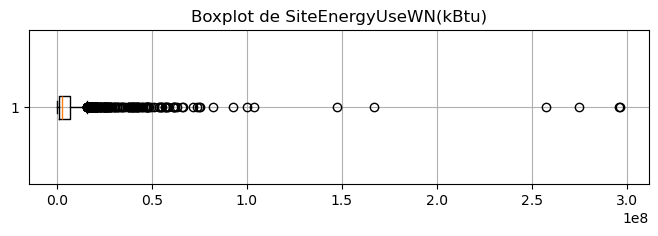

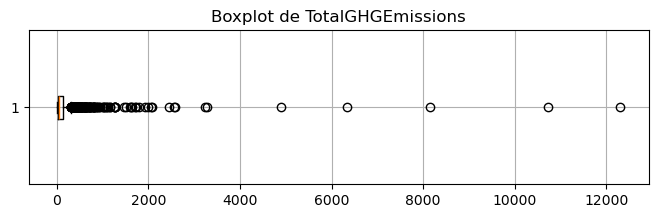

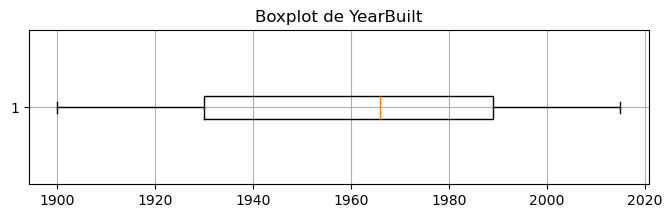

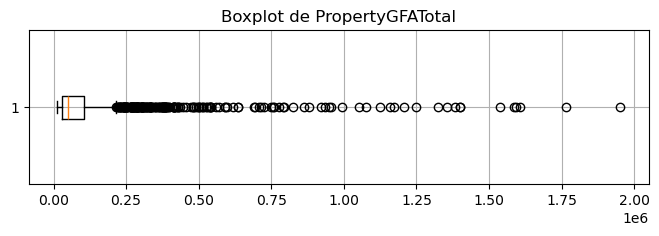

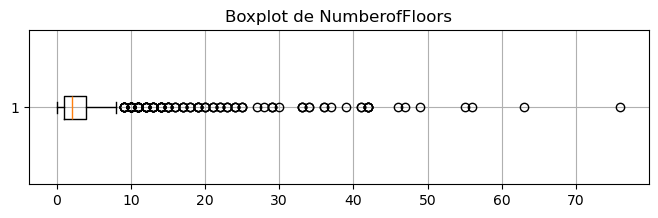

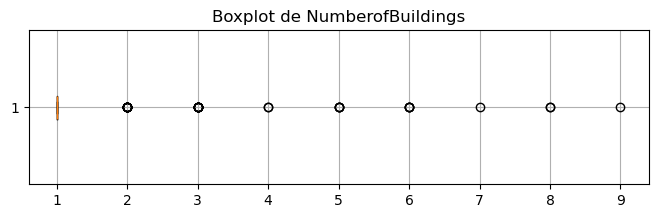

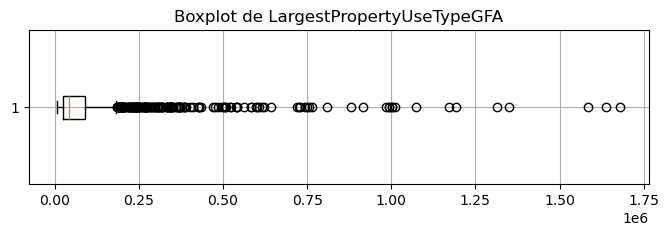

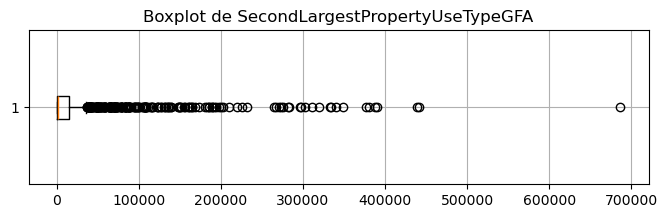

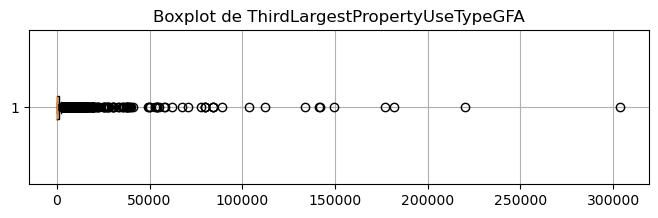

In [179]:
for col in colonnes_numeriques:
    plt.figure(figsize=(8, 2))
    plt.boxplot(df_energy4[col].dropna(), vert=0) 
    plt.title(f'Boxplot de {col}')
    plt.grid(True)
    plt.show()

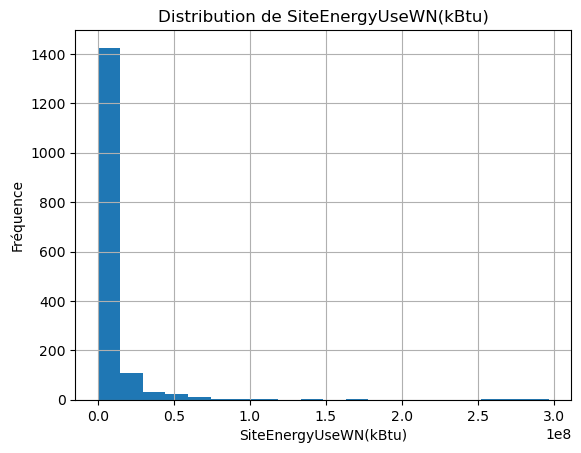

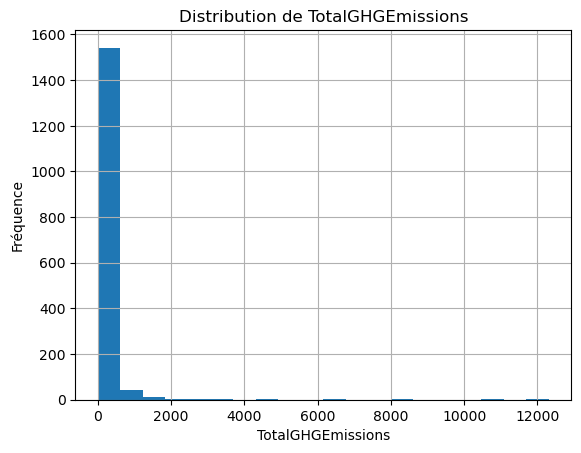

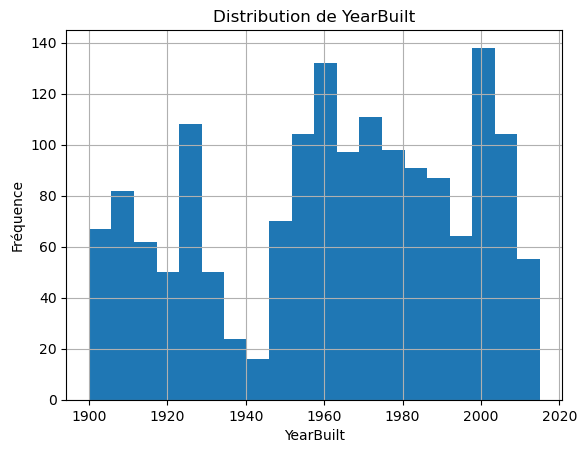

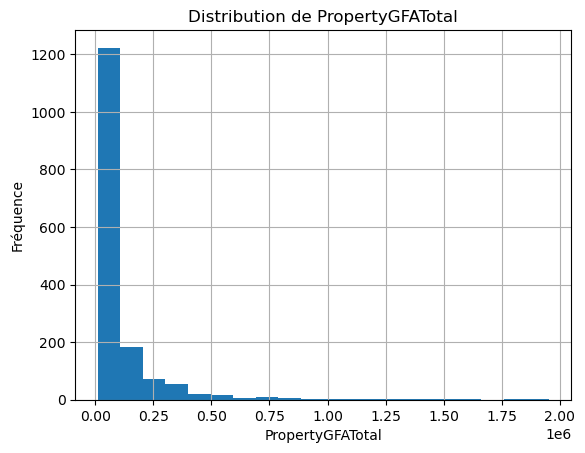

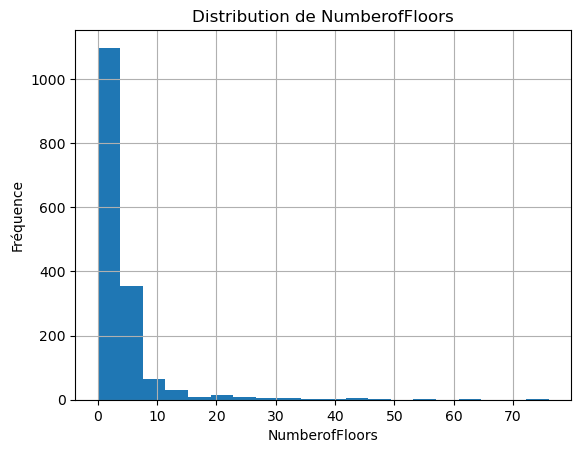

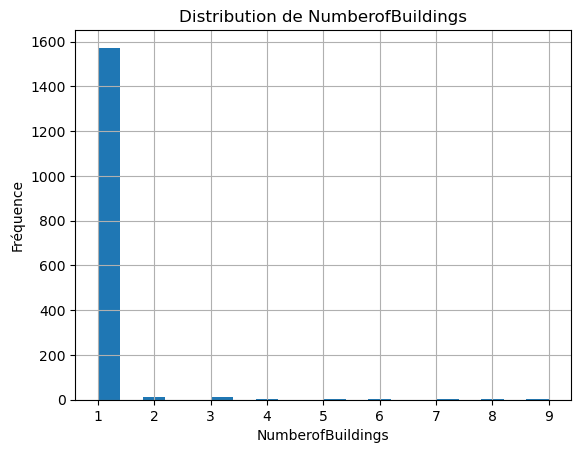

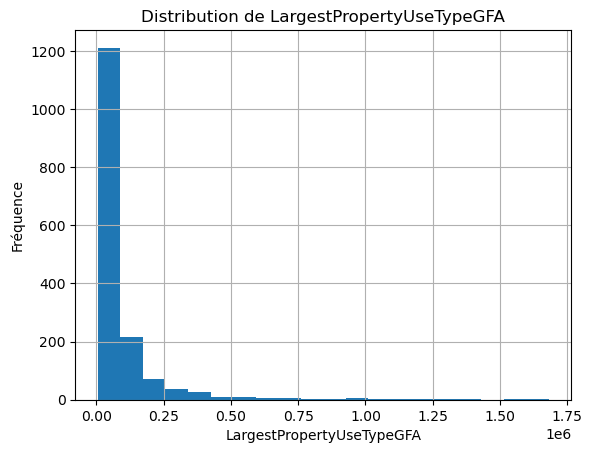

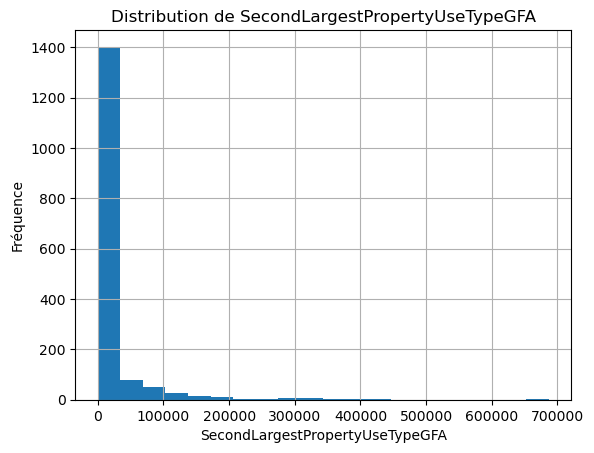

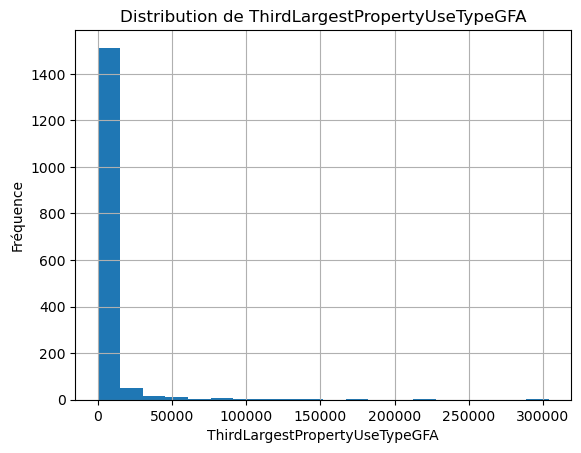

In [180]:
for col in colonnes_numeriques:
    df_energy4[col].hist(bins=20)
    plt.title(f'Distribution de {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Fréquence')
    plt.show()

In [181]:
for col in colonnes_numeriques:
    print(f"Quantiles pour la colonne {col}:")
    print(df_energy4[col].quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]))

Quantiles pour la colonne SiteEnergyUseWN(kBtu):
0.10    6.861834e+05
0.20    1.095800e+06
0.30    1.522111e+06
0.40    2.000558e+06
0.50    2.683695e+06
0.60    3.722980e+06
0.70    5.539328e+06
0.80    8.999687e+06
0.90    1.653221e+07
0.95    2.765812e+07
0.96    3.466737e+07
0.97    4.196612e+07
0.98    4.934855e+07
0.99    6.308169e+07
1.00    2.966717e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64
Quantiles pour la colonne TotalGHGEmissions:
0.10        7.7350
0.20       15.3340
0.30       25.0540
0.40       36.5620
0.50       49.2150
0.60       69.4760
0.70      107.8960
0.80      180.4560
0.90      328.2700
0.95      534.1635
0.96      630.7692
0.97      770.1642
0.98     1055.1800
0.99     1693.9609
1.00    12307.1600
Name: TotalGHGEmissions, dtype: float64
Quantiles pour la colonne YearBuilt:
0.10    1912.0
0.20    1926.0
0.30    1948.0
0.40    1958.0
0.50    1966.0
0.60    1974.0
0.70    1984.3
0.80    1996.0
0.90    2003.0
0.95    2008.0
0.96    2009.0
0.97    2010.0
0.98 

#### *Fréquence*

In [183]:
for col in colonnes_quali:
    print(f"--- Statistiques pour la colonne '{col}' ---")
    
    # Fréquences absolues
    frequencies = df_energy4[col].value_counts()
    print("Fréquences absolues :")
    print(frequencies)
    
    # Fréquences relatives
    frequencies_percent = df_energy4[col].value_counts(normalize=True) * 100 #normalize=True pour donner les proportions et non le nb absolu
    print("\nFréquences relatives (%) :")
    print(frequencies_percent)
    
    print("\n")  # Ajoute une ligne vide entre les colonnes 

--- Statistiques pour la colonne 'PrimaryPropertyType' ---
Fréquences absolues :
PrimaryPropertyType
Small- and Mid-Sized Office    289
Other                          240
Warehouse                      187
Large Office                   169
K-12 School                    133
Mixed Use Property             110
Retail Store                    89
Hotel                           75
Worship Facility                69
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           27
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Residence Hall                   6
Office                           3
Name: count, dtype: int64

Fréquences relatives (%) :
PrimaryPropertyType
Small- and Mid-Sized Office    17.950311
Other                          14.906832
Warehous

#### *Mode*

In [185]:
for col in colonnes_quali:
    print(f"--- Mode pour la colonne '{col}' ---")
    
    # Calcul du mode
    mode_value = df_energy4[col].mode()[0]  # Récupère le premier mode (s'il y a des ex æquo)
    frequency = df_energy4[col].value_counts()[mode_value]  # Fréquence du mode
    frequency_percent = (frequency / len(df_energy4[col])) * 100  # Pourcentage
    
    print(f"Mode : {mode_value}")
    print(f"Fréquence : {frequency} (soit {frequency_percent:.2f}%)\n")

--- Mode pour la colonne 'PrimaryPropertyType' ---
Mode : Small- and Mid-Sized Office
Fréquence : 289 (soit 17.95%)

--- Mode pour la colonne 'Neighborhood' ---
Mode : DOWNTOWN
Fréquence : 349 (soit 21.68%)

--- Mode pour la colonne 'BuildingType' ---
Mode : NonResidential
Fréquence : 1428 (soit 88.70%)

--- Mode pour la colonne 'LargestPropertyUseType' ---
Mode : Office
Fréquence : 490 (soit 30.43%)

--- Mode pour la colonne 'ListOfAllPropertyUseTypes' ---
Mode : Office
Fréquence : 135 (soit 8.39%)

--- Mode pour la colonne 'SecondLargestPropertyUseType' ---
Mode : Absent
Fréquence : 722 (soit 44.84%)

--- Mode pour la colonne 'ThirdLargestPropertyUseType' ---
Mode : Absent
Fréquence : 1151 (soit 71.49%)



## *Feature Engineering*

In [187]:
# Calculer le nombre de valeurs uniques pour chaque colonne
for colonne in colonnes_quali:
    nb_valeurs_uniques = df_energy4[colonne].nunique()  # Compte les valeurs uniques
    print(f"Colonne '{colonne}': {nb_valeurs_uniques} valeurs uniques")

Colonne 'PrimaryPropertyType': 21 valeurs uniques
Colonne 'Neighborhood': 13 valeurs uniques
Colonne 'BuildingType': 4 valeurs uniques
Colonne 'LargestPropertyUseType': 56 valeurs uniques
Colonne 'ListOfAllPropertyUseTypes': 361 valeurs uniques
Colonne 'SecondLargestPropertyUseType': 47 valeurs uniques
Colonne 'ThirdLargestPropertyUseType': 39 valeurs uniques


### 1. Suppression de la variables ListOfAllPropertyUseTypes

In [189]:
df_energy5 = df_energy4.drop(columns='ListOfAllPropertyUseTypes')

In [190]:
display(df_energy5.shape)

(1610, 45)

### 2. Création de % d'utilisation de type d'énergie

In [192]:
print(df_energy5.head())

  OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0             1      2016  NonResidential               Hotel   
1             2      2016  NonResidential               Hotel   
2             3      2016  NonResidential               Hotel   
3             5      2016  NonResidential               Hotel   
4             8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   


In [193]:
print(df_energy5.isna().sum())

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA       0
ThirdLargestPropertyUseType           0


In [194]:
display(df_energy5.loc[df_energy5['Electricity(kBtu)'].isna()])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,GFA_Quantile
560,773,2016,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,98104.0,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,1.0,4,63150,0,63150,Other - Public Services,63150.0,Absent,0.0,Absent,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.150636e+06,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,83.86,NaN,"(49250.5, 76013.333]"
1403,26532,2016,NonResidential,Mixed Use Property,KALBERG BUILDING,4515 UNIVERSITY WAY NE,Seattle,WA,98105.0,8816401120,4,NORTHEAST,47.66182,-122.31345,1928,1.0,2,20760,0,20760,Restaurant,20760.0,Absent,0.0,Absent,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.808066e+05,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,6.69,NaN,"(11284.999, 25840.333]"


In [195]:
#Imputation des valeurs manquantes avec la même technique et hypothèse que pour les variables cibles
# Parcourir chaque combinaison de PrimaryPropertyType et GFA_Quantile
for (primarypropertytype, quantile), group in df_energy5.groupby(['PrimaryPropertyType', 'GFA_Quantile'], observed=True):
    for idx, row in group[group['Electricity(kBtu)'].isna()].iterrows():
        # Chercher la première valeur non-NaN dans le groupe
        close_rows = group[~group['Electricity(kBtu)'].isna()]
        if not close_rows.empty:
            first_value = close_rows['Electricity(kBtu)'].iloc[0]
            df_energy5.at[idx, 'Electricity(kBtu)'] = first_value

In [196]:
# Parcourir chaque combinaison de PrimaryPropertyType et GFA_Quantile
for (primarypropertytype, quantile), group in df_energy5.groupby(['PrimaryPropertyType', 'GFA_Quantile'], observed=True):
    for idx, row in group[group['NaturalGas(kBtu)'].isna()].iterrows():
        # Chercher la première valeur non-NaN dans le groupe
        close_rows = group[~group['NaturalGas(kBtu)'].isna()]
        if not close_rows.empty:
            first_value = close_rows['NaturalGas(kBtu)'].iloc[0]
            df_energy5.at[idx, 'NaturalGas(kBtu)'] = first_value

In [197]:
# Parcourir chaque combinaison de PrimaryPropertyType et GFA_Quantile
for (primarypropertytype, quantile), group in df_energy5.groupby(['PrimaryPropertyType', 'GFA_Quantile'], observed=True):
    for idx, row in group[group['SteamUse(kBtu)'].isna()].iterrows():
        # Chercher la première valeur non-NaN dans le groupe
        close_rows = group[~group['SteamUse(kBtu)'].isna()]
        if not close_rows.empty:
            first_value = close_rows['SteamUse(kBtu)'].iloc[0]
            df_energy5.at[idx, 'SteamUse(kBtu)'] = first_value

In [198]:
#Lorsque division par 0 sinon met NaN
df_energy5['Electricity_%'] = df_energy5.apply(
    lambda row: (row['Electricity(kBtu)'] / row['SiteEnergyUseWN(kBtu)'] * 100) 
    if row['SiteEnergyUseWN(kBtu)'] > 0 else 0, axis=1)

df_energy5['SteamUse(kBtu)_%'] = df_energy5.apply(
    lambda row: (row['SteamUse(kBtu)'] / row['SiteEnergyUseWN(kBtu)'] * 100)
    if row['SiteEnergyUseWN(kBtu)'] > 0 else 0, axis=1)
    
df_energy5['NaturalGas(kBtu)_%'] = df_energy5.apply(
    lambda row: (row['NaturalGas(kBtu)'] / row['SiteEnergyUseWN(kBtu)'] * 100)
    if row['SiteEnergyUseWN(kBtu)'] > 0 else 0, axis=1)

In [199]:
display(df_energy5.head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,GFA_Quantile,Electricity_%,SteamUse(kBtu)_%,NaturalGas(kBtu)_%
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,Absent,0.0,Absent,0.0,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83,"(76013.333, 158569.167]",52.917723,26.872820,17.117720
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86,"(76013.333, 158569.167]",37.426959,0.000000,59.381320
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,Other,199617.0,Absent,0.0,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,NaN,2089.28,2.19,"(158569.167, 1952220.0]",66.984851,29.168781,2.020366
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,61320.0,Absent,0.0,Absent,0.0,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,NaN,286.43,4.67,"(49250.5, 76013.333]",39.858983,31.877211,26.072621
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,NaN,505.01,2.88,"(158569.167, 1952220.0]",36.629522,0.000000,60.068885


In [200]:
display(df_energy5.isna().sum())

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA       0
ThirdLargestPropertyUseType           0


### 3. Mapping observations rares

In [202]:
colonnes_quali=['BuildingType',
                'PrimaryPropertyType',
                'Neighborhood', 
                'LargestPropertyUseType', 
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

In [203]:
for col in colonnes_quali:
    print(f"--- Statistiques pour la colonne '{col}' ---")
    
    # Fréquences absolues
    frequencies = df_energy5[col].value_counts()
    print("Fréquences absolues :")
    print(frequencies)
    
    print("\n")  # Ajoute une ligne vide entre les colonnes 

--- Statistiques pour la colonne 'BuildingType' ---
Fréquences absolues :
BuildingType
NonResidential        1428
SPS-District K-12       97
Nonresidential COS      84
Nonresidential WA        1
Name: count, dtype: int64


--- Statistiques pour la colonne 'PrimaryPropertyType' ---
Fréquences absolues :
PrimaryPropertyType
Small- and Mid-Sized Office    289
Other                          240
Warehouse                      187
Large Office                   169
K-12 School                    133
Mixed Use Property             110
Retail Store                    89
Hotel                           75
Worship Facility                69
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           27
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Residence H

In [204]:
#Pour chaque colonne = mapping pour réassigner les catégories apparaissant une seule fois vers des catégories déjà
#existantes et plus représentatives.

# Pour 'BuildingType'
# "Nonresidential WA" (fréquence = 1) est remplacé par "NonResidential"
mapping_building = {"Nonresidential WA": "NonResidential"}

# Pour 'LargestPropertyUseType'
mapping_largest = {
    "Convention Center": "Other - Public Services",   # Convention Center vers une catégorie public Services
    "Fire Station": "Other - Public Services",          # Fire Station, Courthouse, Police Station regroupés
    "Courthouse": "Other - Public Services",
    "Wholesale Club/Supercenter": "Retail Store",         # Fusionner avec Retail Store (fréquence 97)
    "Police Station": "Other - Public Services",
    "Food Service": "Restaurant",                        # Fusionner avec Restaurant (fréquence 13)
    "Adult Education": "Other - Education",              # Fusionner avec Other - Education
    "Movie Theater": "Other - Entertainment/Public Assembly",  # Fusionner avec une catégorie d'entertainment
    "Personal Services (Health/Beauty, Dry Cleaning, etc)": "Other - Services",  # Regrouper dans Other - Services
    "Residential Care Facility": "Senior Care Community" # Fusionner avec Senior Care Community (fréquence 20)
}

# Pour 'SecondLargestPropertyUseType'
mapping_second = {
    "Pre-school/Daycare": "K-12 School",         
    "Food Sales": "Supermarket/Grocery Store",                         
    "Food Service": "Restaurant",                       
    "Enclosed Mall": "Retail Store",                     
    "College/University": "Adult Education",         
    "Vocational School": "Adult Education",          
    "Personal Services (Health/Beauty, Dry Cleaning, etc)": "Other - Services", 
    "Courthouse": "Other - Public Services",           
    "Residence Hall/Dormitory": "Multifamily Housing", 
    "Other - Lodging/Residential" : "Multifamily Housing",                 
    "Convenience Store without Gas Station": "Retail Store",  
    "Financial Office": "Bank Branch",                 
    "Hospital (General Medical & Surgical)" : "Medical Office",
    "Social/Meeting Hall" : "Other - Entertainment/Public Assembly",
    "Other - Restaurant/Bar" : "Restaurant"
}                                              
# Pour 'ThirdLargestPropertyUseType'
mapping_third = {                    
    "Manufacturing/Industrial Plant": "Non-Refrigerated Warehouse",        
    "Fast Food Restaurant": "Restaurant",                                    
    "Supermarket/Grocery Store": "Retail Store",   
    "Strip Mall": "Retail Store",              
    "Vocational School": "K-12 School",
    "Hotel" : "Multifamily Housing",
    "Other/Specialty Hospital": "Medical Office",
    "Laboratory" : "Other - Technology/Science",
    "Worship Facility" :"Social/Meeting Hall",
    "Bar/Nightclub" : "Other - Entertainment/Public Assembly" 
}

# Application des mappings aux colonnes concernées dans df_energy3
df_energy5['BuildingType'] = df_energy5['BuildingType'].replace(mapping_building)
df_energy5['LargestPropertyUseType'] = df_energy5['LargestPropertyUseType'].replace(mapping_largest)
df_energy5['SecondLargestPropertyUseType'] = df_energy5['SecondLargestPropertyUseType'].replace(mapping_second)
df_energy5['ThirdLargestPropertyUseType']  = df_energy5['ThirdLargestPropertyUseType'].replace(mapping_third)


In [205]:
for col in colonnes_quali:
    print(f"--- Statistiques pour la colonne '{col}' ---")
    
    # Fréquences absolues
    frequencies = df_energy5[col].value_counts()
    print("Fréquences absolues :")
    print(frequencies)
    
    print("\n")  # Ajoute une ligne vide entre les colonnes 

--- Statistiques pour la colonne 'BuildingType' ---
Fréquences absolues :
BuildingType
NonResidential        1429
SPS-District K-12       97
Nonresidential COS      84
Name: count, dtype: int64


--- Statistiques pour la colonne 'PrimaryPropertyType' ---
Fréquences absolues :
PrimaryPropertyType
Small- and Mid-Sized Office    289
Other                          240
Warehouse                      187
Large Office                   169
K-12 School                    133
Mixed Use Property             110
Retail Store                    89
Hotel                           75
Worship Facility                69
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           27
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Residence Hall                   6
Off

### 4. Yearbuilt en âge de bâtiment

In [207]:
from datetime import datetime

# Obtenir l'année actuelle
current_year = datetime.now().year

# Calculer l'âge du bâtiment
df_energy5['BuildingAge'] = current_year - df_energy5['YearBuilt']

In [208]:
display(df_energy5.head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,GFA_Quantile,Electricity_%,SteamUse(kBtu)_%,NaturalGas(kBtu)_%,BuildingAge
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,Absent,0.0,Absent,0.0,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83,"(76013.333, 158569.167]",52.917723,26.872820,17.117720,98
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86,"(76013.333, 158569.167]",37.426959,0.000000,59.381320,29
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,Other,199617.0,Absent,0.0,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,NaN,2089.28,2.19,"(158569.167, 1952220.0]",66.984851,29.168781,2.020366,56
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,61320.0,Absent,0.0,Absent,0.0,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,NaN,286.43,4.67,"(49250.5, 76013.333]",39.858983,31.877211,26.072621,99
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,NaN,505.01,2.88,"(158569.167, 1952220.0]",36.629522,0.000000,60.068885,45


In [209]:
display(df_energy5.shape)

(1610, 49)

### 5. Mise à l'échelle

In [211]:
colonnes_quanti= ['NumberofBuildings', 
                  'NumberofFloors',
                  'PropertyGFATotal',
                  'LargestPropertyUseTypeGFA',
                  'SecondLargestPropertyUseTypeGFA',
                  'ThirdLargestPropertyUseTypeGFA',
                  'Electricity_%',
                  'NaturalGas(kBtu)_%',
                  'SteamUse(kBtu)_%',
                  'BuildingAge']

Test du skewness pour mesurer l'asymétrie des distributions des variables (par rapport à une distribution normale) et le kurtosis (aplatissement) pour mesurer a des queues plus épaisses ou plus fines par rapport à une distribution normale.

#### a. Skewness et Kurtosis

In [214]:
from scipy.stats import skew, kurtosis
df_quanti= df_energy5[colonnes_quanti]

resultats = pd.DataFrame({
    "Variable": df_quanti.columns,
    "Skewness": [skew(df_quanti[col], nan_policy='omit') for col in df_quanti.columns],
    "Kurtosis": [kurtosis(df_quanti[col], nan_policy='omit') for col in df_quanti.columns]
})

print(resultats)

                          Variable   Skewness    Kurtosis
0                NumberofBuildings  10.183519  116.277327
1                   NumberofFloors   5.116773   34.441585
2                 PropertyGFATotal   4.786011   29.172849
3        LargestPropertyUseTypeGFA   5.250706   36.513714
4  SecondLargestPropertyUseTypeGFA   5.201632   36.733839
5   ThirdLargestPropertyUseTypeGFA   9.340637  117.588919
6                    Electricity_%  -0.339141   -0.980219
7               NaturalGas(kBtu)_%   0.424373   -1.113223
8                 SteamUse(kBtu)_%   4.708219   22.202180
9                      BuildingAge   0.301209   -1.025280




**Skewness (Asymétrie)**
- Si Skewness ≈ 0 => La distribution est symétrique (comme une loi normale).
- Si Skewness > 0 => La distribution est asymétrique à droite (queue longue à droite).
- Si Skewness < 0 => La distribution est asymétrique à gauche (queue longue à gauche).
- Si Skewness > 2 => La distribution est fortement asymétrique, il faut faire une transformation

**Kurtosis (Aplatissement)**
- Si Kurtosis ≈ 3 => Distribution mésocurtique (normale).
- Si Kurtosis > 3 => Distribution leptocurtique (beaucoup de valeurs extrêmes).
- Si Kurtosis < 3 =>  Distribution platocurtique (faible présence de valeurs extrêmes).


**Interprétation:**
- NumberofBuildings = fortement asymétrique à droite, avec beaucoup de valeurs extrêmes => A transformer
- NumberofFloors = fortement asymétrique à droite, beaucoup de valeurs extrêmes => A transformer
- PropertyGFATotal = fortement asymétrique à droite, beaucoup de valeurs extrêmes => A transformer
- LargestPropertyUseTypeGFA = Même constat
- SecondLargestPropertyUseTypeGFA = Même constat
- ThirdLargestPropertyUseTypeGF = Même constat
- Electricity_% = distribution presque symétrique un peu asymétrique à gauche, faible présence d'outliers
- NaturalGas(kBtu)_% = distribution presque symétrique, un peu asymétrique à droite, faible présence d 'outliers
- SteamUse(kBtu)_% = distribution asymétrique à droite, avec présence d'outliers
- BuildingAge = distribution presque symétrique, légérement asymétrique à droite avec peu d'outliers

Transformation en log des variables suivantes: 
NumberofBuildings
NumberofFloors
PropertyGFATotal
LargestPropertyUseTypeGFA
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseTypeGFA

#### b. Distribution

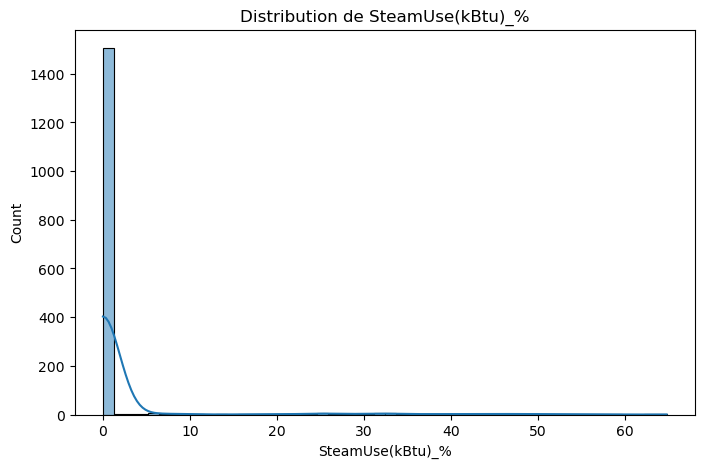

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_energy5["SteamUse(kBtu)_%"], bins=50, kde=True)
plt.title("Distribution de SteamUse(kBtu)_%")
plt.show()


Nous ne ferons pas de transformation logarithmique pour SeamUse puisqu'en % = pourrait transformer en racine carrée ? 

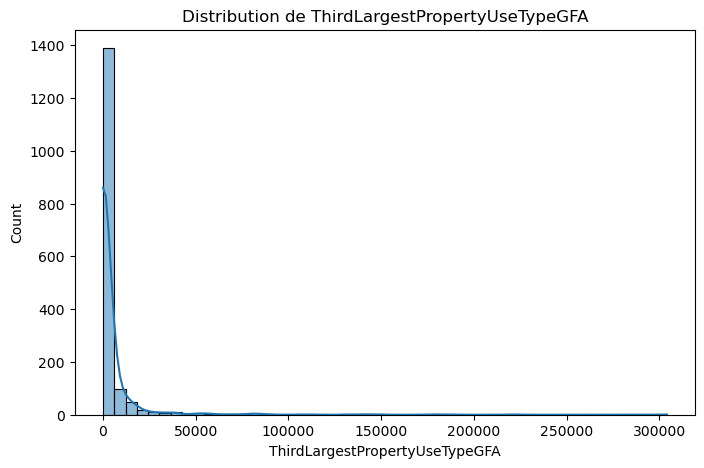

In [220]:
plt.figure(figsize=(8,5))
sns.histplot(df_energy5["ThirdLargestPropertyUseTypeGFA"], bins=50, kde=True)
plt.title("Distribution de ThirdLargestPropertyUseTypeGFA")
plt.show()


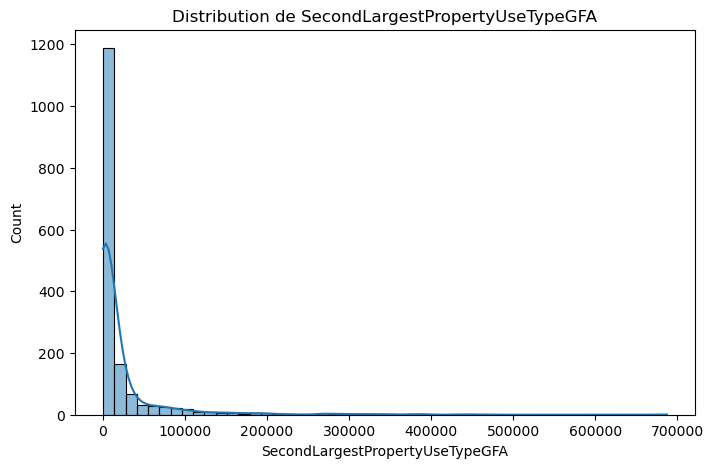

In [221]:
plt.figure(figsize=(8,5))
sns.histplot(df_energy5["SecondLargestPropertyUseTypeGFA"], bins=50, kde=True)
plt.title("Distribution de SecondLargestPropertyUseTypeGFA")
plt.show()

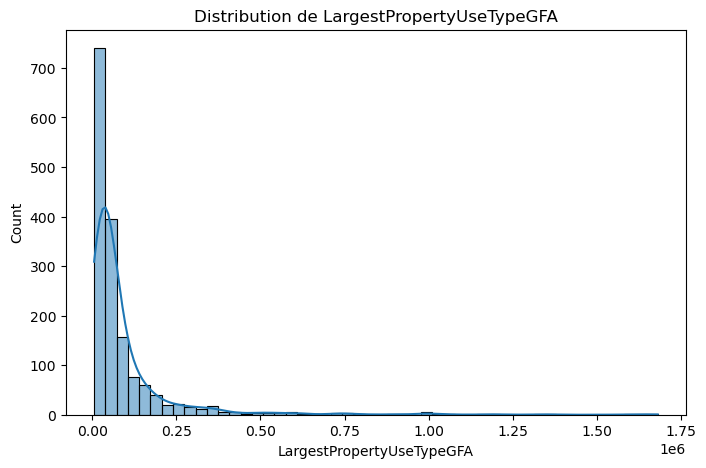

In [222]:
plt.figure(figsize=(8,5))
sns.histplot(df_energy5["LargestPropertyUseTypeGFA"], bins=50, kde=True)
plt.title("Distribution de LargestPropertyUseTypeGFA")
plt.show()

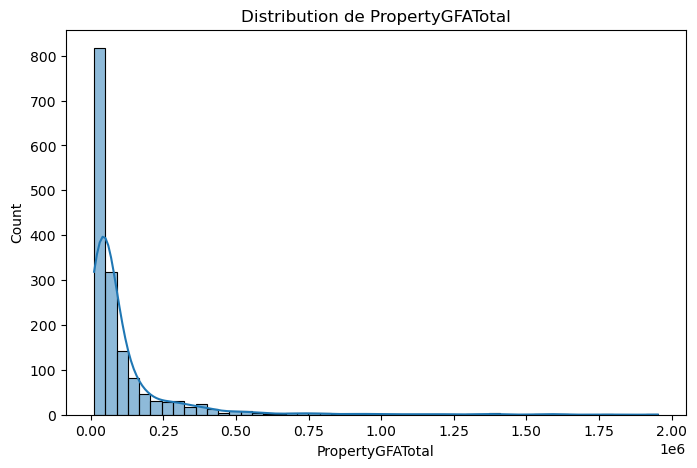

In [223]:
plt.figure(figsize=(8,5))
sns.histplot(df_energy5["PropertyGFATotal"], bins=50, kde=True)
plt.title("Distribution de PropertyGFATotal")
plt.show()

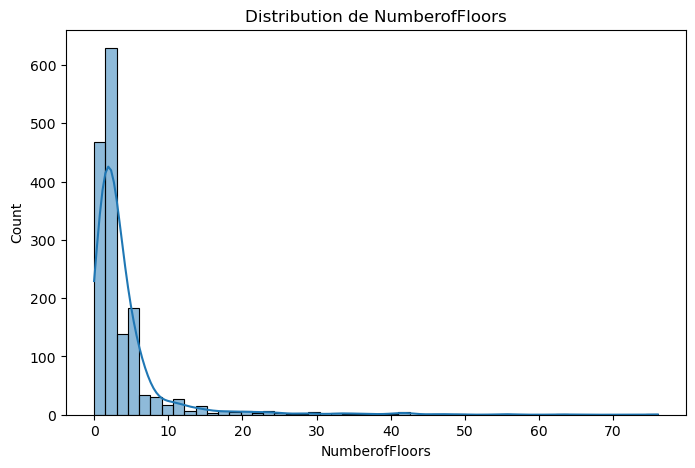

In [224]:
plt.figure(figsize=(8,5))
sns.histplot(df_energy5["NumberofFloors"], bins=50, kde=True)
plt.title("Distribution de NumberofFloors")
plt.show()

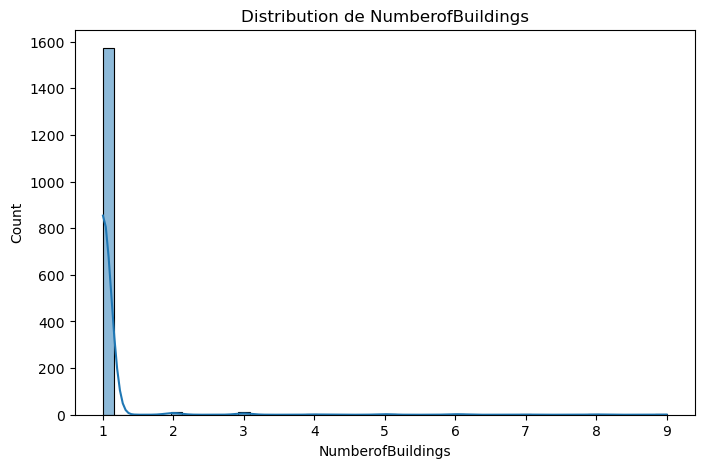

In [225]:
plt.figure(figsize=(8,5))
sns.histplot(df_energy5["NumberofBuildings"], bins=50, kde=True)
plt.title("Distribution de NumberofBuildings")
plt.show()

#### c. Transformation

In [227]:
variables_log= [
    "NumberofBuildings", "NumberofFloors", "PropertyGFATotal",
    "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA"]

# Log transformation (ajouter 1 pour éviter log(0))
for col in variables_log:
    df_energy5[col + "_log"] = np.log1p(df_energy5[col])

In [228]:
display(df_energy5.head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,GFA_Quantile,Electricity_%,SteamUse(kBtu)_%,NaturalGas(kBtu)_%,BuildingAge,NumberofBuildings_log,NumberofFloors_log,PropertyGFATotal_log,LargestPropertyUseTypeGFA_log,SecondLargestPropertyUseTypeGFA_log,ThirdLargestPropertyUseTypeGFA_log
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,Absent,0.0,Absent,0.0,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83,"(76013.333, 158569.167]",52.917723,26.872820,17.117720,98,0.693147,2.564949,11.390023,11.390023,0.000000,0.000000
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86,"(76013.333, 158569.167]",37.426959,0.000000,59.381320,29,0.693147,2.484907,11.547974,11.337154,9.620129,8.438799
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,756493.0,Other,199617.0,Absent,0.0,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,NaN,2089.28,2.19,"(158569.167, 1952220.0]",66.984851,29.168781,2.020366,56,0.693147,3.737670,13.770629,13.536450,12.204161,0.000000
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,61320.0,Absent,0.0,Absent,0.0,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,NaN,286.43,4.67,"(49250.5, 76013.333]",39.858983,31.877211,26.072621,99,0.693147,2.397895,11.023878,11.023878,0.000000,0.000000
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,NaN,505.01,2.88,"(158569.167, 1952220.0]",36.629522,0.000000,60.068885,45,0.693147,2.944439,12.075856,11.723559,11.127410,0.000000


In [229]:
df_energy5["SteamUse(kBtu)_%_sqrt"] = np.sqrt(df_energy5["SteamUse(kBtu)_%"])

## *Corrélation*

In [231]:
colonnes_quanti= ['NumberofBuildings', 
                  'NumberofFloors',
                  'PropertyGFATotal',
                  'LargestPropertyUseTypeGFA',
                  'SecondLargestPropertyUseTypeGFA',
                  'ThirdLargestPropertyUseTypeGFA',
                  'Electricity_%',
                  'NaturalGas(kBtu)_%',
                  'SteamUse(kBtu)_%',
                  'BuildingAge',
                  'ENERGYSTARScore',
                  'TotalGHGEmissions',
                  'SiteEnergyUseWN(kBtu)']

In [232]:
colonnes_quanti_transformed= ["NumberofBuildings_log",
                              "NumberofFloors_log",
                              "PropertyGFATotal_log",
                              "LargestPropertyUseTypeGFA_log",
                              "SecondLargestPropertyUseTypeGFA_log",
                              "ThirdLargestPropertyUseTypeGFA_log",
                              'Electricity_%',
                              'NaturalGas(kBtu)_%',
                              "SteamUse(kBtu)_%_sqrt",
                              'BuildingAge',
                             'TotalGHGEmissions',
                              'SiteEnergyUseWN(kBtu)']

In [233]:
colonnes_quali=['BuildingType',
                'PrimaryPropertyType',
                'Neighborhood', 
                'LargestPropertyUseType', 
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

### *Matrice de corrélations entres les variables quantitatives et les cibles*

In [235]:
correlation_matrix = df_energy5[colonnes_quanti].corr()
print(correlation_matrix)

                                 NumberofBuildings  NumberofFloors  \
NumberofBuildings                         1.000000       -0.010053   
NumberofFloors                           -0.010053        1.000000   
PropertyGFATotal                          0.184603        0.726303   
LargestPropertyUseTypeGFA                 0.250006        0.697109   
SecondLargestPropertyUseTypeGFA           0.170370        0.523902   
ThirdLargestPropertyUseTypeGFA           -0.004601        0.337368   
Electricity_%                            -0.039807        0.164170   
NaturalGas(kBtu)_%                        0.041956       -0.209961   
SteamUse(kBtu)_%                          0.066250        0.160862   
BuildingAge                              -0.040341       -0.098691   
ENERGYSTARScore                          -0.059208        0.127589   
TotalGHGEmissions                         0.540209        0.206424   
SiteEnergyUseWN(kBtu)                     0.447928        0.421604   

                   

In [236]:
correlation_matrix_transformed = df_energy5[colonnes_quanti_transformed].corr()
print(correlation_matrix_transformed)

                                     NumberofBuildings_log  \
NumberofBuildings_log                             1.000000   
NumberofFloors_log                               -0.020008   
PropertyGFATotal_log                              0.118611   
LargestPropertyUseTypeGFA_log                     0.131373   
SecondLargestPropertyUseTypeGFA_log              -0.001146   
ThirdLargestPropertyUseTypeGFA_log               -0.017418   
Electricity_%                                    -0.037402   
NaturalGas(kBtu)_%                                0.045786   
SteamUse(kBtu)_%_sqrt                             0.047040   
BuildingAge                                      -0.046127   
TotalGHGEmissions                                 0.473585   
SiteEnergyUseWN(kBtu)                             0.393336   

                                     NumberofFloors_log  PropertyGFATotal_log  \
NumberofBuildings_log                         -0.020008              0.118611   
NumberofFloors_log             

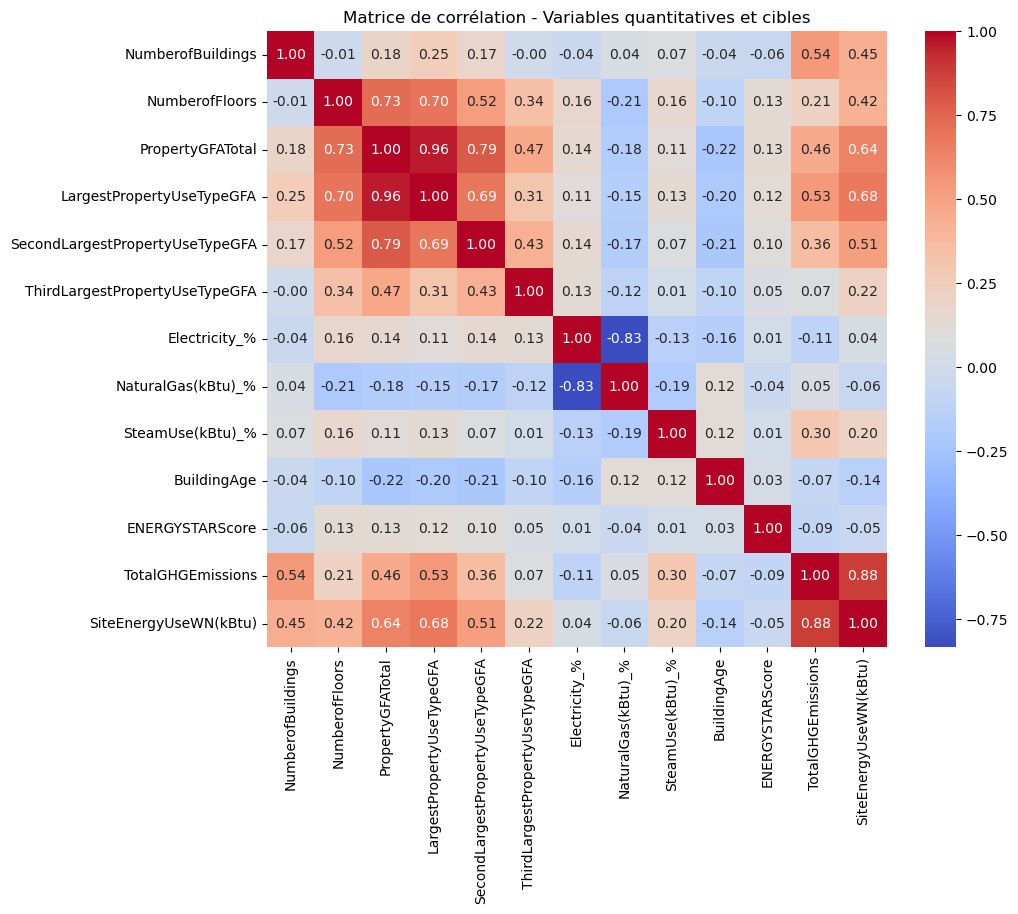

In [237]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation - Variables quantitatives et cibles")
plt.show()

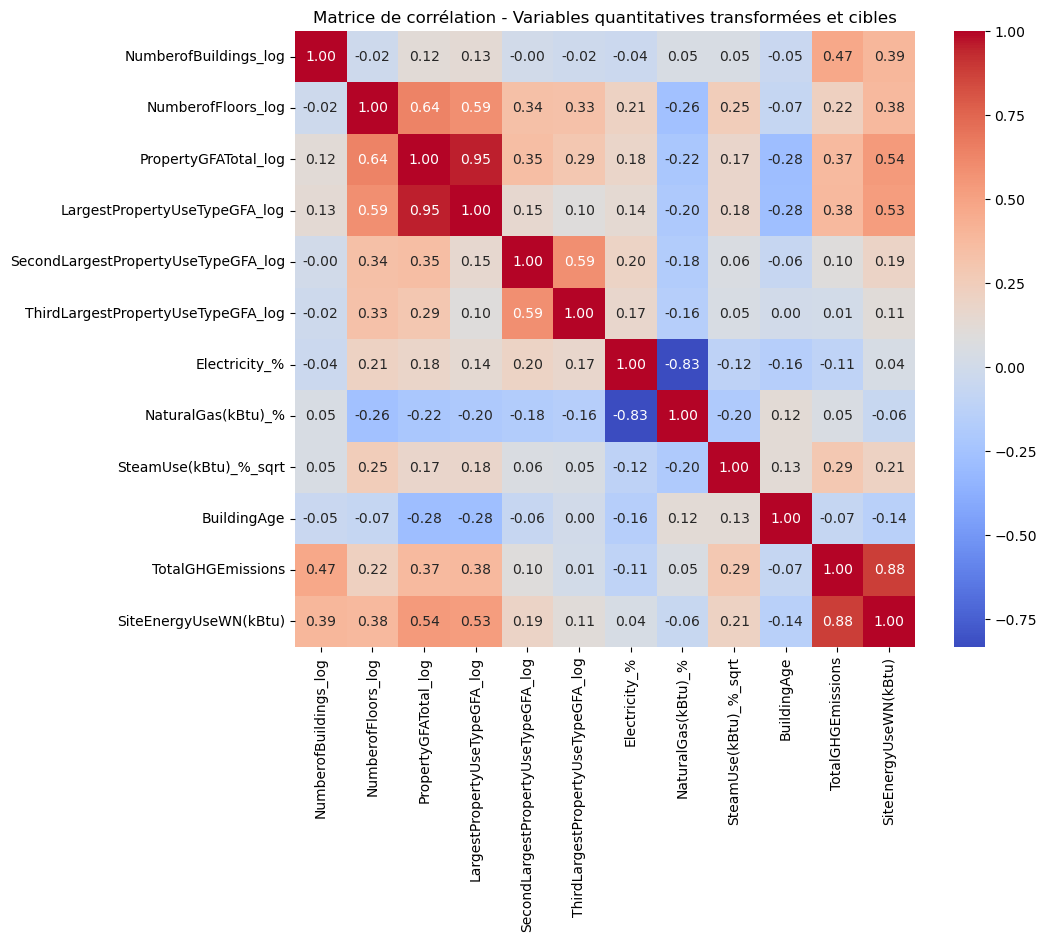

In [238]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_transformed, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation - Variables quantitatives transformées et cibles")
plt.show()

### *Test entre les variables qualitatives et cibles*

#### *TotalGHGEmissions*

Test d'indépendance de Chi² = permet de tester si deux variables catégorielles sont indépendantes l'une de l'autre = compare les fréquences observées avec les fréquences attendues si les variables étaient indépendantes.

- Hypothèse nulle (H0) : Les deux variables sont indépendantes
- Hypothèse alternative (H1) : Les deux variables ne sont pas indépendantes

Les variables cibles étant quantitatives, je dois discrétiser ces variables en catégories.
La discrétisation est effectuée ici en utilisant pd.qcut, qui divise en 8 quantiles.
Le paramètre "labels=False" attribue un nombre entier (de 0 à 7) pour chaque catégorie, ce qui rend la variable catégorielle.

In [242]:
from scipy.stats import chi2_contingency

# Discrétisation de la variable quantitative
df_energy5['TotalGHGEmissions_cat'] = pd.qcut(df_energy5['TotalGHGEmissions'], q=8, labels=False)

#Boucle pour créer pour chaque features quali la table de contingence pd.crosstab
for col in colonnes_quali:
    contingency_table = pd.crosstab(df_energy5[col], df_energy5['TotalGHGEmissions_cat'])#tableau de contingence
    chi2, p_value, _, _ = chi2_contingency(contingency_table) #renvoie la statistique Chi² et le p-value
    # _,_ car pas intéressé par dof (degré de liberté du test) et expected (fréquences attendues sous l'hypothèse d'indépendance) pour simplifier les résultats
    print(f"Chi2 pour {col} et TotalGHGEmissions: p-value = {p_value}, Chi² = {chi2}")
    #Si le p-value est inférieur à 0.05 les variables sont associées.

Chi2 pour BuildingType et TotalGHGEmissions: p-value = 0.0003648353188218136, Chi² = 38.99919693533765
Chi2 pour PrimaryPropertyType et TotalGHGEmissions: p-value = 5.959313639535879e-84, Chi² = 749.025448257909
Chi2 pour Neighborhood et TotalGHGEmissions: p-value = 1.0633379939437723e-07, Chi² = 169.27961325374508
Chi2 pour LargestPropertyUseType et TotalGHGEmissions: p-value = 3.438572037313877e-41, Chi² = 778.7794433154602
Chi2 pour SecondLargestPropertyUseType et TotalGHGEmissions: p-value = 0.006331813195740377, Chi² = 272.40121118459894
Chi2 pour ThirdLargestPropertyUseType et TotalGHGEmissions: p-value = 0.12895818263791767, Chi² = 218.54952042487767


#### *SiteEnergyUseWN(kBtu)*

In [244]:
# Discrétisation de la variable quantitative
df_energy5['SiteEnergyUseWN(kBtu)_cat'] = pd.qcut(df_energy5['SiteEnergyUseWN(kBtu)'], q=8, labels=False)

#Boucle pour créer pour chaque features quali la table de contingence pd.crosstab
for col in colonnes_quali:
    contingency_table = pd.crosstab(df_energy5[col], df_energy5['SiteEnergyUseWN(kBtu)_cat'])#tableau de contingence
    chi2, p_value, _, _ = chi2_contingency(contingency_table) #renvoie la statistique Chi² et le p-value
    # _,_ car pas intéressé par dof (degré de liberté du test) et expected (fréquences attendues sous l'hypothèse d'indépendance) pour simplifier les résultats
    print(f"Chi2 pour {col} et SiteEnergyUseWN(kBtu): p-value = {p_value}, Chi² = {chi2}")
    #Si le p-value est inférieur à 0.05 les variables sont associées.

Chi2 pour BuildingType et SiteEnergyUseWN(kBtu): p-value = 6.476526256542697e-09, Chi² = 67.08505578303263
Chi2 pour PrimaryPropertyType et SiteEnergyUseWN(kBtu): p-value = 5.121537745840572e-139, Chi² = 1048.9649563916232
Chi2 pour Neighborhood et SiteEnergyUseWN(kBtu): p-value = 5.990758404080496e-17, Chi² = 240.05557090573757
Chi2 pour LargestPropertyUseType et SiteEnergyUseWN(kBtu): p-value = 9.17249755603484e-59, Chi² = 907.3606460697424
Chi2 pour SecondLargestPropertyUseType et SiteEnergyUseWN(kBtu): p-value = 7.309861562223303e-13, Chi² = 398.6468929729858
Chi2 pour ThirdLargestPropertyUseType et SiteEnergyUseWN(kBtu): p-value = 5.509892202682574e-06, Chi² = 295.5309040530953


In [245]:
df_energy5.to_csv("df_energy5.csv", index=False)  # index=False pour ne pas sauvegarder l'index

In [246]:
display(df_energy5.shape)

(1610, 58)